## image classification기법 사용

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset, he_init_weights
from models.image_classifier import ResNetLike
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
source_data_dir = "../../data/source_data"
label_file_path = "../../data/label_data/label_mapping_sampled.csv"

In [4]:
patch_size = 7 #patch_size 설정
num_epochs = 100 #에포크 수

### 테스트 지역 선별  
train data와 validaiton data가 인접한 패치가 되면 일반화 성능을 올바르게 검증 할 수 없을 것이다.  
따라서 train data에서 사용한 지역과 어느정도는 떯어진 지역의 패치를 validation data로 이용하도록 한다.  
3000*3000의 정사각형 지역(이미지)를 300*300 크기의 지역 100개로 나눈 후 이중 임의로 약 20개를 뽑아서 validation data로 이용했다.  
아래는 validation data의 위치를 시각화 하는 코드이다.(빨간색이 테스트 지역임)

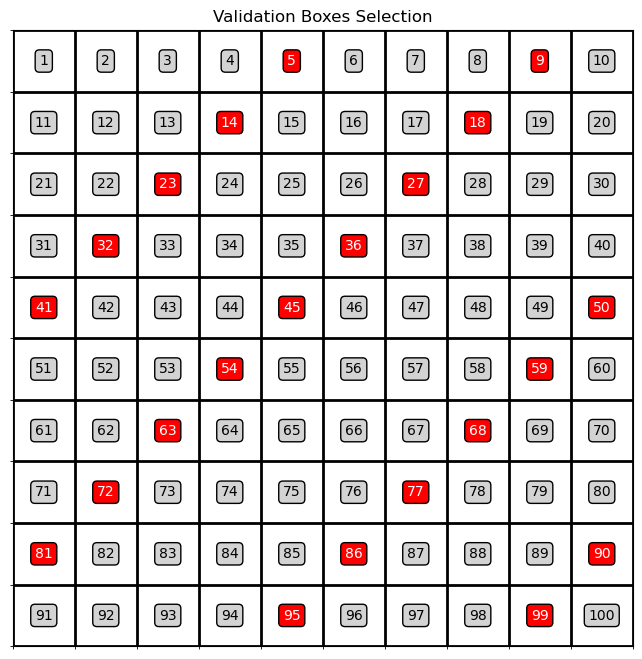

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 10x10 격자에서 1부터 100까지 박스 번호 생성 (책 읽는 순서로)
grid_size = 10
box_numbers = np.arange(1, 101).reshape((grid_size, grid_size), order='C')[::-1]

# 테스트 필터 정의
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

# 테스트할 박스 선택
test_boxes = np.vectorize(test_filter)(box_numbers)

# 시각화
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(grid_size + 1) - 0.5, minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

# 박스에 숫자 표시 및 색상 적용
for i in range(grid_size):
    for j in range(grid_size):
        box_number = box_numbers[i, j]
        ax.text(j, i, str(box_number), ha='center', va='center', fontsize=10, 
                color='white' if test_boxes[i, j] else 'black', 
                bbox=dict(facecolor='red' if test_boxes[i, j] else 'lightgray', 
                          edgecolor='black', boxstyle='round,pad=0.3'))

# 축을 숨김
ax.set_xticks([])
ax.set_yticks([])

plt.title("Validation Boxes Selection")
plt.show()


### 데이터 전처리 방법 설정 - naive

In [6]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

## B, G, R, NIR 데이터만 사용

In [7]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"naive"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform,
    patch_size = patch_size
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"naive"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform,
    patch_size = patch_size
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.61it/s]



Epoch [1/100], Train Loss: 0.4803, Train Accuracy: 82.23%, Val Loss: 0.4663, Val Accuracy: 84.51%



Epoch 2/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.72it/s]



Epoch [2/100], Train Loss: 0.3696, Train Accuracy: 86.37%, Val Loss: 0.4112, Val Accuracy: 86.67%



Epoch 3/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.58it/s]



Epoch [3/100], Train Loss: 0.3274, Train Accuracy: 88.10%, Val Loss: 0.5083, Val Accuracy: 83.98%



Epoch 4/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.76it/s]



Epoch [4/100], Train Loss: 0.3017, Train Accuracy: 89.04%, Val Loss: 0.3864, Val Accuracy: 87.74%



Epoch 5/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.08it/s]



Epoch [5/100], Train Loss: 0.2822, Train Accuracy: 89.71%, Val Loss: 0.4415, Val Accuracy: 86.65%



Epoch 6/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.97it/s]



Epoch [6/100], Train Loss: 0.2700, Train Accuracy: 90.22%, Val Loss: 0.4900, Val Accuracy: 85.29%



Epoch 7/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.78it/s]



Epoch [7/100], Train Loss: 0.2585, Train Accuracy: 90.67%, Val Loss: 0.4312, Val Accuracy: 86.73%



Epoch 8/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.09it/s]



Epoch [8/100], Train Loss: 0.2460, Train Accuracy: 91.07%, Val Loss: 0.4182, Val Accuracy: 87.40%



Epoch 9/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.67it/s]



Epoch [9/100], Train Loss: 0.2376, Train Accuracy: 91.40%, Val Loss: 0.4378, Val Accuracy: 87.00%



Epoch 10/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.33it/s]



Epoch [10/100], Train Loss: 0.2300, Train Accuracy: 91.71%, Val Loss: 0.4170, Val Accuracy: 87.44%



Epoch 11/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.08it/s]



Epoch [11/100], Train Loss: 0.2253, Train Accuracy: 91.76%, Val Loss: 0.4627, Val Accuracy: 85.79%



Epoch 12/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.50it/s]



Epoch [12/100], Train Loss: 0.2196, Train Accuracy: 91.97%, Val Loss: 0.4625, Val Accuracy: 85.94%



Epoch 13/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.77it/s]



Epoch [13/100], Train Loss: 0.2122, Train Accuracy: 92.32%, Val Loss: 0.4909, Val Accuracy: 85.65%



Epoch 14/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.17it/s]



Epoch [14/100], Train Loss: 0.2068, Train Accuracy: 92.52%, Val Loss: 0.4958, Val Accuracy: 86.04%



Epoch 15/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.15it/s]



Epoch [15/100], Train Loss: 0.2051, Train Accuracy: 92.49%, Val Loss: 0.4509, Val Accuracy: 87.15%



Epoch 16/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.97it/s]



Epoch [16/100], Train Loss: 0.2001, Train Accuracy: 92.69%, Val Loss: 0.4407, Val Accuracy: 87.11%



Epoch 17/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.38it/s]



Epoch [17/100], Train Loss: 0.1946, Train Accuracy: 92.94%, Val Loss: 0.5099, Val Accuracy: 84.85%



Epoch 18/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.49it/s]



Epoch [18/100], Train Loss: 0.1938, Train Accuracy: 93.04%, Val Loss: 0.4663, Val Accuracy: 86.65%



Epoch 19/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.52it/s]



Epoch [19/100], Train Loss: 0.1906, Train Accuracy: 93.08%, Val Loss: 0.4535, Val Accuracy: 87.59%



Epoch 20/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.72it/s]



Epoch [20/100], Train Loss: 0.1866, Train Accuracy: 93.20%, Val Loss: 0.4076, Val Accuracy: 88.41%



Epoch 21/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.74it/s]



Epoch [21/100], Train Loss: 0.1850, Train Accuracy: 93.18%, Val Loss: 0.4440, Val Accuracy: 87.48%



Epoch 22/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.87it/s]



Epoch [22/100], Train Loss: 0.1813, Train Accuracy: 93.39%, Val Loss: 0.4574, Val Accuracy: 86.79%



Epoch 23/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.32it/s]



Epoch [23/100], Train Loss: 0.1782, Train Accuracy: 93.55%, Val Loss: 0.4608, Val Accuracy: 87.52%



Epoch 24/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.67it/s]



Epoch [24/100], Train Loss: 0.1754, Train Accuracy: 93.60%, Val Loss: 0.5082, Val Accuracy: 86.19%



Epoch 25/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.65it/s]



Epoch [25/100], Train Loss: 0.1724, Train Accuracy: 93.71%, Val Loss: 0.4244, Val Accuracy: 88.13%



Epoch 26/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.27it/s]



Epoch [26/100], Train Loss: 0.1724, Train Accuracy: 93.69%, Val Loss: 0.4763, Val Accuracy: 87.02%



Epoch 27/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.28it/s]



Epoch [27/100], Train Loss: 0.1678, Train Accuracy: 93.87%, Val Loss: 0.4801, Val Accuracy: 86.81%



Epoch 28/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.79it/s]



Epoch [28/100], Train Loss: 0.1659, Train Accuracy: 93.94%, Val Loss: 0.5023, Val Accuracy: 87.09%



Epoch 29/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.26it/s]



Epoch [29/100], Train Loss: 0.1645, Train Accuracy: 94.07%, Val Loss: 0.4751, Val Accuracy: 86.70%



Epoch 30/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.25it/s]



Epoch [30/100], Train Loss: 0.1631, Train Accuracy: 94.12%, Val Loss: 0.4708, Val Accuracy: 87.86%



Epoch 31/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.84it/s]



Epoch [31/100], Train Loss: 0.1615, Train Accuracy: 94.12%, Val Loss: 0.4711, Val Accuracy: 87.49%



Epoch 32/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.84it/s]



Epoch [32/100], Train Loss: 0.1587, Train Accuracy: 94.21%, Val Loss: 0.4713, Val Accuracy: 87.40%



Epoch 33/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.63it/s]



Epoch [33/100], Train Loss: 0.1563, Train Accuracy: 94.30%, Val Loss: 0.4565, Val Accuracy: 87.25%



Epoch 34/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.96it/s]



Epoch [34/100], Train Loss: 0.1564, Train Accuracy: 94.27%, Val Loss: 0.5244, Val Accuracy: 86.81%



Epoch 35/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.99it/s]



Epoch [35/100], Train Loss: 0.1545, Train Accuracy: 94.37%, Val Loss: 0.4714, Val Accuracy: 87.52%



Epoch 36/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.26it/s]



Epoch [36/100], Train Loss: 0.1545, Train Accuracy: 94.37%, Val Loss: 0.4662, Val Accuracy: 88.02%



Epoch 37/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.90it/s]



Epoch [37/100], Train Loss: 0.1514, Train Accuracy: 94.48%, Val Loss: 0.5004, Val Accuracy: 87.14%



Epoch 38/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.73it/s]



Epoch [38/100], Train Loss: 0.1503, Train Accuracy: 94.49%, Val Loss: 0.5131, Val Accuracy: 85.32%



Epoch 39/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.35it/s]



Epoch [39/100], Train Loss: 0.1500, Train Accuracy: 94.48%, Val Loss: 0.5045, Val Accuracy: 86.95%



Epoch 40/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.16it/s]



Epoch [40/100], Train Loss: 0.1470, Train Accuracy: 94.65%, Val Loss: 0.8811, Val Accuracy: 73.36%



Epoch 41/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.01it/s]



Epoch [41/100], Train Loss: 0.1468, Train Accuracy: 94.66%, Val Loss: 0.5031, Val Accuracy: 87.43%



Epoch 42/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.48it/s]



Epoch [42/100], Train Loss: 0.1449, Train Accuracy: 94.63%, Val Loss: 0.5137, Val Accuracy: 86.49%



Epoch 43/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.94it/s]



Epoch [43/100], Train Loss: 0.1420, Train Accuracy: 94.82%, Val Loss: 0.6067, Val Accuracy: 83.54%



Epoch 44/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.72it/s]



Epoch [44/100], Train Loss: 0.1414, Train Accuracy: 94.84%, Val Loss: 0.5076, Val Accuracy: 87.41%



Epoch 45/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.79it/s]



Epoch [45/100], Train Loss: 0.1412, Train Accuracy: 94.87%, Val Loss: 0.5386, Val Accuracy: 85.65%



Epoch 46/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.14it/s]



Epoch [46/100], Train Loss: 0.1406, Train Accuracy: 94.88%, Val Loss: 0.4928, Val Accuracy: 86.23%



Epoch 47/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.93it/s]



Epoch [47/100], Train Loss: 0.1399, Train Accuracy: 94.92%, Val Loss: 0.5253, Val Accuracy: 87.21%



Epoch 48/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.95it/s]



Epoch [48/100], Train Loss: 0.1363, Train Accuracy: 94.95%, Val Loss: 0.4754, Val Accuracy: 88.24%



Epoch 49/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.82it/s]



Epoch [49/100], Train Loss: 0.1370, Train Accuracy: 94.99%, Val Loss: 0.6009, Val Accuracy: 85.69%



Epoch 50/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.02it/s]



Epoch [50/100], Train Loss: 0.1344, Train Accuracy: 95.07%, Val Loss: 0.5337, Val Accuracy: 86.93%



Epoch 51/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.62it/s]



Epoch [51/100], Train Loss: 0.1342, Train Accuracy: 95.10%, Val Loss: 0.5131, Val Accuracy: 86.91%



Epoch 52/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.06it/s]



Epoch [52/100], Train Loss: 0.1338, Train Accuracy: 95.17%, Val Loss: 0.5242, Val Accuracy: 87.49%



Epoch 53/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.75it/s]



Epoch [53/100], Train Loss: 0.1312, Train Accuracy: 95.17%, Val Loss: 0.4806, Val Accuracy: 88.47%



Epoch 54/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.37it/s]



Epoch [54/100], Train Loss: 0.1305, Train Accuracy: 95.22%, Val Loss: 0.5371, Val Accuracy: 86.70%



Epoch 55/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.94it/s]



Epoch [55/100], Train Loss: 0.1306, Train Accuracy: 95.18%, Val Loss: 0.5025, Val Accuracy: 87.11%



Epoch 56/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.26it/s]



Epoch [56/100], Train Loss: 0.1282, Train Accuracy: 95.28%, Val Loss: 0.5035, Val Accuracy: 87.09%



Epoch 57/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.66it/s]



Epoch [57/100], Train Loss: 0.1286, Train Accuracy: 95.31%, Val Loss: 0.4881, Val Accuracy: 87.01%



Epoch 58/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.01it/s]



Epoch [58/100], Train Loss: 0.1286, Train Accuracy: 95.31%, Val Loss: 0.5333, Val Accuracy: 87.14%



Epoch 59/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.59it/s]



Epoch [59/100], Train Loss: 0.1254, Train Accuracy: 95.42%, Val Loss: 0.4840, Val Accuracy: 87.94%



Epoch 60/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.34it/s]



Epoch [60/100], Train Loss: 0.1264, Train Accuracy: 95.36%, Val Loss: 0.5036, Val Accuracy: 86.94%



Epoch 61/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.94it/s]



Epoch [61/100], Train Loss: 0.1253, Train Accuracy: 95.43%, Val Loss: 0.5280, Val Accuracy: 85.95%



Epoch 62/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.77it/s]



Epoch [62/100], Train Loss: 0.1221, Train Accuracy: 95.56%, Val Loss: 0.5101, Val Accuracy: 87.13%



Epoch 63/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.34it/s]



Epoch [63/100], Train Loss: 0.1231, Train Accuracy: 95.49%, Val Loss: 0.4881, Val Accuracy: 87.47%



Epoch 64/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.89it/s]



Epoch [64/100], Train Loss: 0.1222, Train Accuracy: 95.53%, Val Loss: 0.4975, Val Accuracy: 88.54%



Epoch 65/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.23it/s]



Epoch [65/100], Train Loss: 0.1217, Train Accuracy: 95.51%, Val Loss: 0.5248, Val Accuracy: 86.55%



Epoch 66/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.56it/s]



Epoch [66/100], Train Loss: 0.1200, Train Accuracy: 95.64%, Val Loss: 0.4653, Val Accuracy: 87.89%



Epoch 67/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.55it/s]



Epoch [67/100], Train Loss: 0.1201, Train Accuracy: 95.67%, Val Loss: 0.5082, Val Accuracy: 86.36%



Epoch 68/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.46it/s]



Epoch [68/100], Train Loss: 0.1178, Train Accuracy: 95.67%, Val Loss: 0.4630, Val Accuracy: 87.95%



Epoch 69/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.74it/s]



Epoch [69/100], Train Loss: 0.1190, Train Accuracy: 95.66%, Val Loss: 0.5214, Val Accuracy: 85.79%



Epoch 70/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.47it/s]



Epoch [70/100], Train Loss: 0.1168, Train Accuracy: 95.74%, Val Loss: 0.4893, Val Accuracy: 87.98%



Epoch 71/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.94it/s]



Epoch [71/100], Train Loss: 0.1177, Train Accuracy: 95.76%, Val Loss: 0.5650, Val Accuracy: 85.73%



Epoch 72/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.02it/s]



Epoch [72/100], Train Loss: 0.1160, Train Accuracy: 95.77%, Val Loss: 0.5538, Val Accuracy: 86.21%



Epoch 73/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.42it/s]



Epoch [73/100], Train Loss: 0.1140, Train Accuracy: 95.82%, Val Loss: 0.4793, Val Accuracy: 87.78%



Epoch 74/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.51it/s]



Epoch [74/100], Train Loss: 0.1158, Train Accuracy: 95.74%, Val Loss: 0.6259, Val Accuracy: 85.78%



Epoch 75/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.50it/s]



Epoch [75/100], Train Loss: 0.1139, Train Accuracy: 95.86%, Val Loss: 0.5339, Val Accuracy: 87.96%



Epoch 76/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.46it/s]



Epoch [76/100], Train Loss: 0.1134, Train Accuracy: 95.83%, Val Loss: 0.5136, Val Accuracy: 88.00%



Epoch 77/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.07it/s]



Epoch [77/100], Train Loss: 0.1149, Train Accuracy: 95.76%, Val Loss: 0.5376, Val Accuracy: 86.28%



Epoch 78/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.96it/s]



Epoch [78/100], Train Loss: 0.1129, Train Accuracy: 95.89%, Val Loss: 0.5175, Val Accuracy: 87.94%



Epoch 79/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.12it/s]



Epoch [79/100], Train Loss: 0.1127, Train Accuracy: 95.91%, Val Loss: 0.5809, Val Accuracy: 87.70%



Epoch 80/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.98it/s]



Epoch [80/100], Train Loss: 0.1112, Train Accuracy: 95.90%, Val Loss: 0.5250, Val Accuracy: 87.24%



Epoch 81/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.55it/s]



Epoch [81/100], Train Loss: 0.1098, Train Accuracy: 95.95%, Val Loss: 0.5366, Val Accuracy: 87.10%



Epoch 82/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.74it/s]



Epoch [82/100], Train Loss: 0.1098, Train Accuracy: 96.01%, Val Loss: 0.5660, Val Accuracy: 86.35%



Epoch 83/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 222.31it/s]



Epoch [83/100], Train Loss: 0.1069, Train Accuracy: 96.04%, Val Loss: 0.6016, Val Accuracy: 86.98%



Epoch 84/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.06it/s]



Epoch [84/100], Train Loss: 0.1092, Train Accuracy: 96.03%, Val Loss: 0.4784, Val Accuracy: 87.65%



Epoch 85/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.53it/s]



Epoch [85/100], Train Loss: 0.1082, Train Accuracy: 96.06%, Val Loss: 0.6108, Val Accuracy: 86.69%



Epoch 86/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.05it/s]



Epoch [86/100], Train Loss: 0.1090, Train Accuracy: 95.99%, Val Loss: 0.5161, Val Accuracy: 86.97%



Epoch 87/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.35it/s]



Epoch [87/100], Train Loss: 0.1061, Train Accuracy: 96.08%, Val Loss: 0.5533, Val Accuracy: 87.74%



Epoch 88/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 221.05it/s]



Epoch [88/100], Train Loss: 0.1053, Train Accuracy: 96.11%, Val Loss: 0.5897, Val Accuracy: 85.76%



Epoch 89/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.13it/s]



Epoch [89/100], Train Loss: 0.1044, Train Accuracy: 96.19%, Val Loss: 0.4973, Val Accuracy: 88.53%



Epoch 90/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.04it/s]



Epoch [90/100], Train Loss: 0.1059, Train Accuracy: 96.13%, Val Loss: 0.5171, Val Accuracy: 87.54%



Epoch 91/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 218.90it/s]



Epoch [91/100], Train Loss: 0.1063, Train Accuracy: 96.11%, Val Loss: 0.4844, Val Accuracy: 88.02%



Epoch 92/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 218.61it/s]



Epoch [92/100], Train Loss: 0.1052, Train Accuracy: 96.14%, Val Loss: 0.5827, Val Accuracy: 86.35%



Epoch 93/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.74it/s]



Epoch [93/100], Train Loss: 0.1048, Train Accuracy: 96.17%, Val Loss: 0.5375, Val Accuracy: 87.64%



Epoch 94/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.25it/s]



Epoch [94/100], Train Loss: 0.1025, Train Accuracy: 96.25%, Val Loss: 0.5978, Val Accuracy: 87.21%



Epoch 95/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.54it/s]



Epoch [95/100], Train Loss: 0.1043, Train Accuracy: 96.17%, Val Loss: 0.5267, Val Accuracy: 87.63%



Epoch 96/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 219.42it/s]



Epoch [96/100], Train Loss: 0.1010, Train Accuracy: 96.32%, Val Loss: 0.6468, Val Accuracy: 85.55%



Epoch 97/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.75it/s]



Epoch [97/100], Train Loss: 0.1025, Train Accuracy: 96.29%, Val Loss: 0.5610, Val Accuracy: 88.00%



Epoch 98/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.36it/s]



Epoch [98/100], Train Loss: 0.1016, Train Accuracy: 96.24%, Val Loss: 0.6429, Val Accuracy: 84.29%



Epoch 99/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 223.30it/s]



Epoch [99/100], Train Loss: 0.1014, Train Accuracy: 96.25%, Val Loss: 0.5582, Val Accuracy: 87.43%



Epoch 100/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 220.84it/s]



Epoch [100/100], Train Loss: 0.1008, Train Accuracy: 96.31%, Val Loss: 0.5774, Val Accuracy: 87.45%


train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:16<00:00, 220.53it/s]


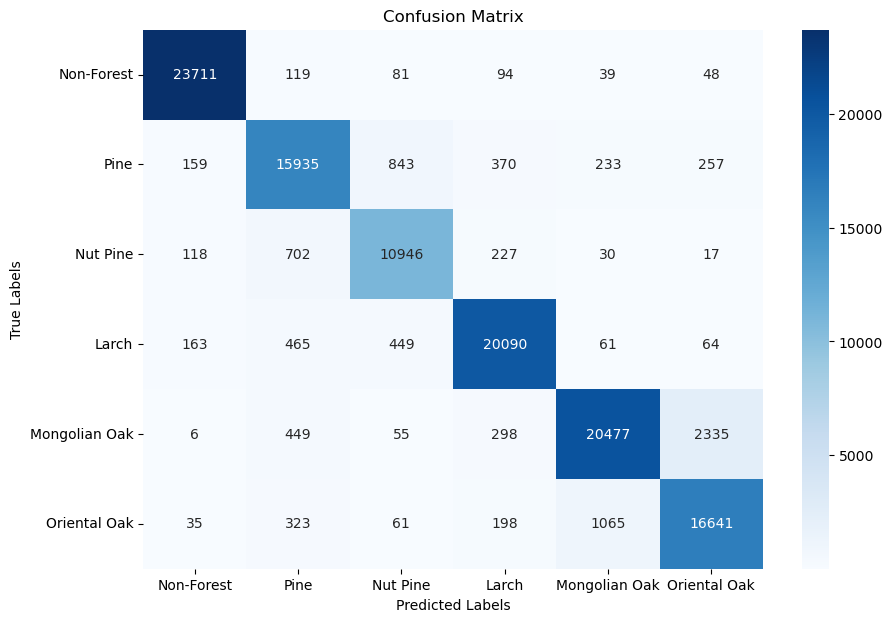

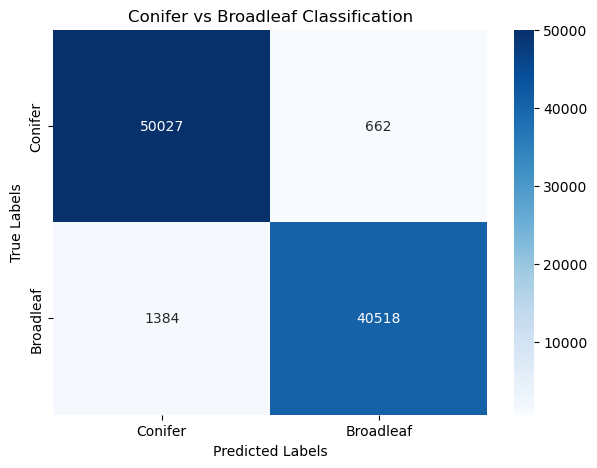

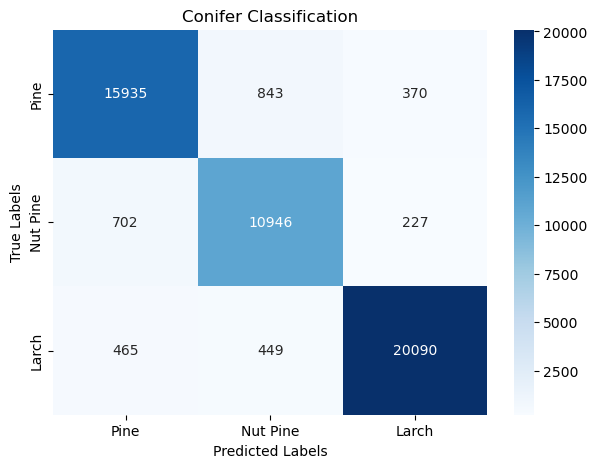

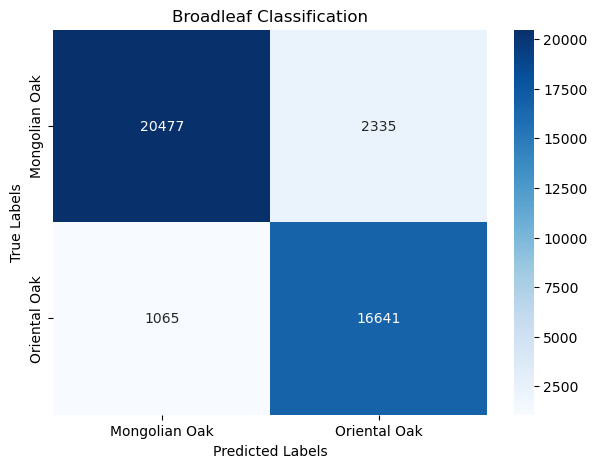


validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:05<00:00, 225.29it/s]


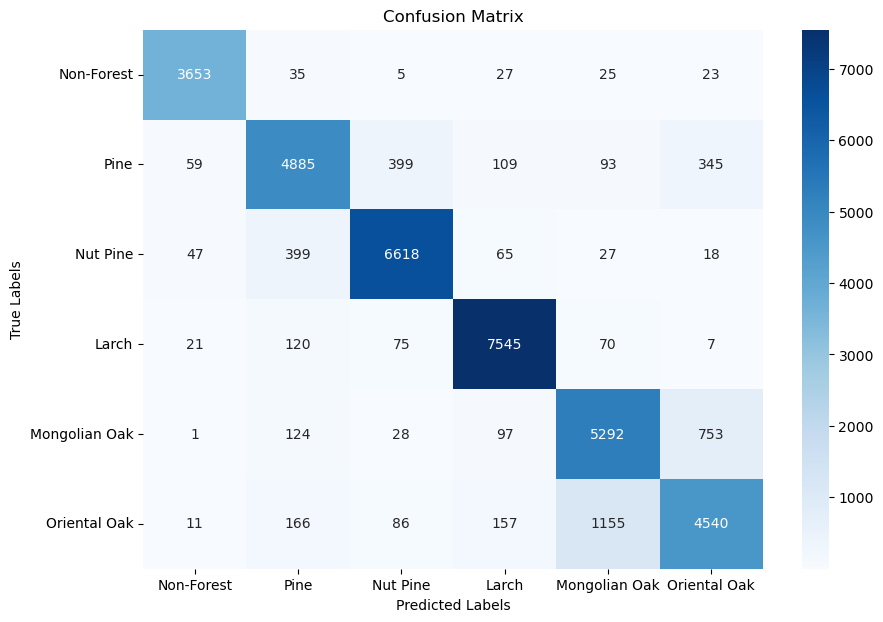

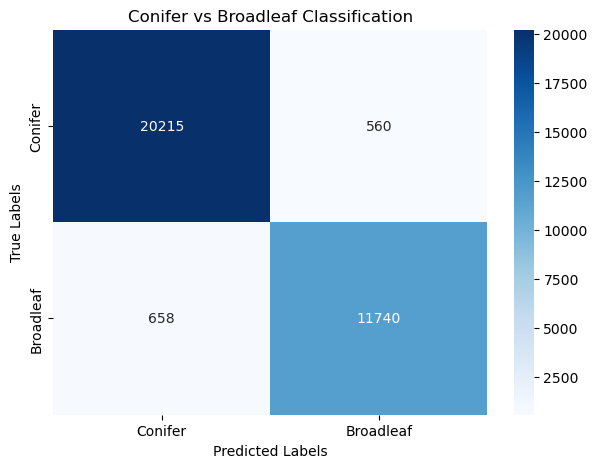

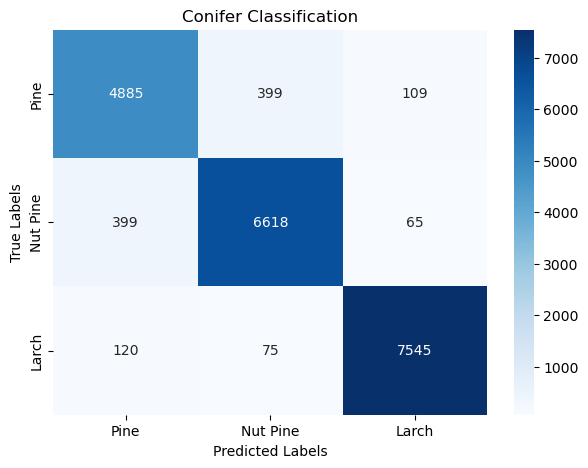

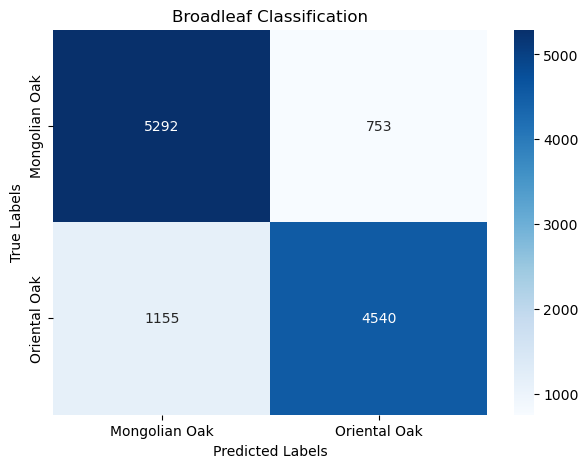

,precision,recall,f1-score,support,Category
Non-Forest,0.963344,0.969480,0.966402,3768.000000,Overall
Pine,0.852679,0.829372,0.840864,5890.000000,Overall
Nut Pine,0.917765,0.922498,0.920125,7174.000000,Overall
Larch,0.943125,0.962618,0.952772,7838.000000,Overall
Mongolian Oak,0.794356,0.840667,0.816856,6295.000000,Overall
Oriental Oak,0.798452,0.742437,0.769426,6115.000000,Overall
accuracy,0.877373,0.877373,0.877373,0.877373,Overall
macro avg,0.878287,0.877845,0.877741,37080.000000,Overall
weighted avg,0.876791,0.877373,0.876754,37080.000000,Overall
Conifer,0.968476,0.973045,0.970755,20775.000000,Conifer vs Broadleaf


In [8]:
model = ResNetLike(input_channels=48, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
)
os.makedirs("./checkpoints/image_classification",exist_ok=True)
torch.save(best_model_state, f"./checkpoints/image_classification/ResNetLike_48_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI도 추가된 데이터 사용

In [9]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform,
    patch_size = patch_size
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform,
    patch_size = patch_size
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.87it/s]



Epoch [1/100], Train Loss: 0.4730, Train Accuracy: 82.60%, Val Loss: 0.5354, Val Accuracy: 81.06%



Epoch 2/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.43it/s]



Epoch [2/100], Train Loss: 0.3615, Train Accuracy: 86.71%, Val Loss: 0.4294, Val Accuracy: 86.32%



Epoch 3/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.19it/s]



Epoch [3/100], Train Loss: 0.3189, Train Accuracy: 88.31%, Val Loss: 0.4439, Val Accuracy: 86.90%



Epoch 4/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.91it/s]



Epoch [4/100], Train Loss: 0.2917, Train Accuracy: 89.37%, Val Loss: 0.4497, Val Accuracy: 85.98%



Epoch 5/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.56it/s]



Epoch [5/100], Train Loss: 0.2707, Train Accuracy: 90.04%, Val Loss: 0.4548, Val Accuracy: 86.44%



Epoch 6/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.14it/s]



Epoch [6/100], Train Loss: 0.2550, Train Accuracy: 90.73%, Val Loss: 0.4788, Val Accuracy: 86.87%



Epoch 7/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.61it/s]



Epoch [7/100], Train Loss: 0.2417, Train Accuracy: 91.20%, Val Loss: 0.4333, Val Accuracy: 87.24%



Epoch 8/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.14it/s]



Epoch [8/100], Train Loss: 0.2319, Train Accuracy: 91.53%, Val Loss: 0.4924, Val Accuracy: 86.11%



Epoch 9/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.60it/s]



Epoch [9/100], Train Loss: 0.2233, Train Accuracy: 91.80%, Val Loss: 0.4010, Val Accuracy: 88.14%



Epoch 10/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.09it/s]



Epoch [10/100], Train Loss: 0.2140, Train Accuracy: 92.19%, Val Loss: 0.4484, Val Accuracy: 86.42%



Epoch 11/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.48it/s]



Epoch [11/100], Train Loss: 0.2079, Train Accuracy: 92.41%, Val Loss: 0.4589, Val Accuracy: 86.76%



Epoch 12/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.65it/s]



Epoch [12/100], Train Loss: 0.2027, Train Accuracy: 92.62%, Val Loss: 0.4420, Val Accuracy: 87.28%



Epoch 13/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.74it/s]



Epoch [13/100], Train Loss: 0.1962, Train Accuracy: 92.87%, Val Loss: 0.4691, Val Accuracy: 87.03%



Epoch 14/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.56it/s]



Epoch [14/100], Train Loss: 0.1935, Train Accuracy: 93.02%, Val Loss: 0.4552, Val Accuracy: 87.06%



Epoch 15/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.81it/s]



Epoch [15/100], Train Loss: 0.1879, Train Accuracy: 93.19%, Val Loss: 0.4979, Val Accuracy: 87.57%



Epoch 16/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.92it/s]



Epoch [16/100], Train Loss: 0.1826, Train Accuracy: 93.31%, Val Loss: 0.5464, Val Accuracy: 87.67%



Epoch 17/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.09it/s]



Epoch [17/100], Train Loss: 0.1809, Train Accuracy: 93.42%, Val Loss: 0.5090, Val Accuracy: 87.18%



Epoch 18/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 208.69it/s]



Epoch [18/100], Train Loss: 0.1753, Train Accuracy: 93.63%, Val Loss: 0.4974, Val Accuracy: 85.30%



Epoch 19/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.13it/s]



Epoch [19/100], Train Loss: 0.1713, Train Accuracy: 93.75%, Val Loss: 0.6532, Val Accuracy: 81.78%



Epoch 20/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.61it/s]



Epoch [20/100], Train Loss: 0.1690, Train Accuracy: 93.88%, Val Loss: 0.4763, Val Accuracy: 87.72%



Epoch 21/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.87it/s]



Epoch [21/100], Train Loss: 0.1653, Train Accuracy: 94.02%, Val Loss: 0.4587, Val Accuracy: 87.83%



Epoch 22/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.64it/s]



Epoch [22/100], Train Loss: 0.1647, Train Accuracy: 94.09%, Val Loss: 0.4489, Val Accuracy: 87.99%



Epoch 23/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.14it/s]



Epoch [23/100], Train Loss: 0.1606, Train Accuracy: 94.13%, Val Loss: 0.5289, Val Accuracy: 87.53%



Epoch 24/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.58it/s]



Epoch [24/100], Train Loss: 0.1587, Train Accuracy: 94.27%, Val Loss: 0.5538, Val Accuracy: 86.46%



Epoch 25/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.09it/s]



Epoch [25/100], Train Loss: 0.1548, Train Accuracy: 94.34%, Val Loss: 0.5656, Val Accuracy: 86.29%



Epoch 26/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.99it/s]



Epoch [26/100], Train Loss: 0.1519, Train Accuracy: 94.40%, Val Loss: 0.5419, Val Accuracy: 87.74%



Epoch 27/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.96it/s]



Epoch [27/100], Train Loss: 0.1522, Train Accuracy: 94.41%, Val Loss: 0.6499, Val Accuracy: 85.06%



Epoch 28/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.82it/s]



Epoch [28/100], Train Loss: 0.1482, Train Accuracy: 94.56%, Val Loss: 0.4934, Val Accuracy: 87.22%



Epoch 29/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.08it/s]



Epoch [29/100], Train Loss: 0.1463, Train Accuracy: 94.73%, Val Loss: 0.5363, Val Accuracy: 87.78%



Epoch 30/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.22it/s]



Epoch [30/100], Train Loss: 0.1418, Train Accuracy: 94.82%, Val Loss: 0.4928, Val Accuracy: 87.44%



Epoch 31/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.96it/s]



Epoch [31/100], Train Loss: 0.1435, Train Accuracy: 94.72%, Val Loss: 0.5696, Val Accuracy: 86.08%



Epoch 32/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.14it/s]



Epoch [32/100], Train Loss: 0.1410, Train Accuracy: 94.86%, Val Loss: 0.5393, Val Accuracy: 87.75%



Epoch 33/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.88it/s]



Epoch [33/100], Train Loss: 0.1387, Train Accuracy: 94.89%, Val Loss: 0.6379, Val Accuracy: 85.55%



Epoch 34/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.78it/s]



Epoch [34/100], Train Loss: 0.1364, Train Accuracy: 95.00%, Val Loss: 0.5687, Val Accuracy: 86.59%



Epoch 35/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.87it/s]



Epoch [35/100], Train Loss: 0.1368, Train Accuracy: 95.06%, Val Loss: 0.5555, Val Accuracy: 87.27%



Epoch 36/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.33it/s]



Epoch [36/100], Train Loss: 0.1332, Train Accuracy: 95.17%, Val Loss: 0.5202, Val Accuracy: 87.35%



Epoch 37/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.03it/s]



Epoch [37/100], Train Loss: 0.1329, Train Accuracy: 95.16%, Val Loss: 0.5163, Val Accuracy: 87.10%



Epoch 38/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.79it/s]



Epoch [38/100], Train Loss: 0.1305, Train Accuracy: 95.23%, Val Loss: 0.5086, Val Accuracy: 87.72%



Epoch 39/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.88it/s]



Epoch [39/100], Train Loss: 0.1288, Train Accuracy: 95.29%, Val Loss: 0.5794, Val Accuracy: 86.79%



Epoch 40/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.97it/s]



Epoch [40/100], Train Loss: 0.1271, Train Accuracy: 95.31%, Val Loss: 0.4981, Val Accuracy: 86.89%



Epoch 41/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.96it/s]



Epoch [41/100], Train Loss: 0.1270, Train Accuracy: 95.45%, Val Loss: 0.5388, Val Accuracy: 87.16%



Epoch 42/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 208.83it/s]



Epoch [42/100], Train Loss: 0.1253, Train Accuracy: 95.45%, Val Loss: 0.5476, Val Accuracy: 85.68%



Epoch 43/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.48it/s]



Epoch [43/100], Train Loss: 0.1229, Train Accuracy: 95.54%, Val Loss: 0.6309, Val Accuracy: 85.94%



Epoch 44/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.97it/s]



Epoch [44/100], Train Loss: 0.1240, Train Accuracy: 95.45%, Val Loss: 0.5991, Val Accuracy: 85.04%



Epoch 45/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.84it/s]



Epoch [45/100], Train Loss: 0.1215, Train Accuracy: 95.64%, Val Loss: 0.5512, Val Accuracy: 87.41%



Epoch 46/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.79it/s]



Epoch [46/100], Train Loss: 0.1213, Train Accuracy: 95.52%, Val Loss: 0.5953, Val Accuracy: 87.28%



Epoch 47/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.95it/s]



Epoch [47/100], Train Loss: 0.1189, Train Accuracy: 95.65%, Val Loss: 0.6028, Val Accuracy: 87.51%



Epoch 48/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.60it/s]



Epoch [48/100], Train Loss: 0.1173, Train Accuracy: 95.72%, Val Loss: 0.6117, Val Accuracy: 86.52%



Epoch 49/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 205.78it/s]



Epoch [49/100], Train Loss: 0.1179, Train Accuracy: 95.75%, Val Loss: 0.6913, Val Accuracy: 84.52%



Epoch 50/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.90it/s]



Epoch [50/100], Train Loss: 0.1171, Train Accuracy: 95.68%, Val Loss: 0.5833, Val Accuracy: 87.01%



Epoch 51/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.87it/s]



Epoch [51/100], Train Loss: 0.1127, Train Accuracy: 95.83%, Val Loss: 0.5718, Val Accuracy: 87.75%



Epoch 52/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.29it/s]



Epoch [52/100], Train Loss: 0.1125, Train Accuracy: 95.90%, Val Loss: 0.6459, Val Accuracy: 85.18%



Epoch 53/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.59it/s]



Epoch [53/100], Train Loss: 0.1137, Train Accuracy: 95.83%, Val Loss: 0.6720, Val Accuracy: 86.50%



Epoch 54/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 208.99it/s]



Epoch [54/100], Train Loss: 0.1102, Train Accuracy: 95.94%, Val Loss: 0.6434, Val Accuracy: 86.11%



Epoch 55/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.66it/s]



Epoch [55/100], Train Loss: 0.1127, Train Accuracy: 95.88%, Val Loss: 0.6773, Val Accuracy: 86.44%



Epoch 56/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.54it/s]



Epoch [56/100], Train Loss: 0.1093, Train Accuracy: 95.99%, Val Loss: 0.6201, Val Accuracy: 86.58%



Epoch 57/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.58it/s]



Epoch [57/100], Train Loss: 0.1090, Train Accuracy: 96.01%, Val Loss: 0.5874, Val Accuracy: 87.15%



Epoch 58/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.92it/s]



Epoch [58/100], Train Loss: 0.1082, Train Accuracy: 95.97%, Val Loss: 0.5754, Val Accuracy: 86.45%



Epoch 59/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.39it/s]



Epoch [59/100], Train Loss: 0.1074, Train Accuracy: 96.14%, Val Loss: 0.6136, Val Accuracy: 87.07%



Epoch 60/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.98it/s]



Epoch [60/100], Train Loss: 0.1064, Train Accuracy: 96.01%, Val Loss: 0.5925, Val Accuracy: 86.60%



Epoch 61/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.47it/s]



Epoch [61/100], Train Loss: 0.1057, Train Accuracy: 96.14%, Val Loss: 0.6716, Val Accuracy: 84.44%



Epoch 62/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.66it/s]



Epoch [62/100], Train Loss: 0.1042, Train Accuracy: 96.17%, Val Loss: 0.6057, Val Accuracy: 86.04%



Epoch 63/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 208.38it/s]



Epoch [63/100], Train Loss: 0.1042, Train Accuracy: 96.17%, Val Loss: 0.8358, Val Accuracy: 82.67%



Epoch 64/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.78it/s]



Epoch [64/100], Train Loss: 0.1024, Train Accuracy: 96.28%, Val Loss: 0.6197, Val Accuracy: 86.77%



Epoch 65/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.62it/s]



Epoch [65/100], Train Loss: 0.1016, Train Accuracy: 96.25%, Val Loss: 0.6519, Val Accuracy: 86.45%



Epoch 66/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.67it/s]



Epoch [66/100], Train Loss: 0.1012, Train Accuracy: 96.27%, Val Loss: 0.6440, Val Accuracy: 85.45%



Epoch 67/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.77it/s]



Epoch [67/100], Train Loss: 0.1010, Train Accuracy: 96.31%, Val Loss: 0.6823, Val Accuracy: 85.83%



Epoch 68/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.06it/s]



Epoch [68/100], Train Loss: 0.0990, Train Accuracy: 96.38%, Val Loss: 0.7063, Val Accuracy: 86.13%



Epoch 69/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.76it/s]



Epoch [69/100], Train Loss: 0.0999, Train Accuracy: 96.36%, Val Loss: 0.7105, Val Accuracy: 86.14%



Epoch 70/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.42it/s]



Epoch [70/100], Train Loss: 0.0984, Train Accuracy: 96.42%, Val Loss: 0.6345, Val Accuracy: 86.32%



Epoch 71/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.74it/s]



Epoch [71/100], Train Loss: 0.0982, Train Accuracy: 96.40%, Val Loss: 0.7372, Val Accuracy: 85.84%



Epoch 72/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.32it/s]



Epoch [72/100], Train Loss: 0.0955, Train Accuracy: 96.53%, Val Loss: 0.7089, Val Accuracy: 86.56%



Epoch 73/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.68it/s]



Epoch [73/100], Train Loss: 0.0972, Train Accuracy: 96.48%, Val Loss: 0.7442, Val Accuracy: 85.56%



Epoch 74/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.63it/s]



Epoch [74/100], Train Loss: 0.0933, Train Accuracy: 96.65%, Val Loss: 0.6392, Val Accuracy: 87.23%



Epoch 75/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.85it/s]



Epoch [75/100], Train Loss: 0.0954, Train Accuracy: 96.48%, Val Loss: 0.7275, Val Accuracy: 86.04%



Epoch 76/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.79it/s]



Epoch [76/100], Train Loss: 0.0954, Train Accuracy: 96.56%, Val Loss: 0.7086, Val Accuracy: 86.00%



Epoch 77/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.82it/s]



Epoch [77/100], Train Loss: 0.0955, Train Accuracy: 96.48%, Val Loss: 0.6109, Val Accuracy: 86.96%



Epoch 78/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.98it/s]



Epoch [78/100], Train Loss: 0.0929, Train Accuracy: 96.56%, Val Loss: 0.6854, Val Accuracy: 87.14%



Epoch 79/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.07it/s]



Epoch [79/100], Train Loss: 0.0920, Train Accuracy: 96.62%, Val Loss: 0.5782, Val Accuracy: 88.19%



Epoch 80/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.32it/s]



Epoch [80/100], Train Loss: 0.0925, Train Accuracy: 96.61%, Val Loss: 0.7542, Val Accuracy: 85.59%



Epoch 81/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.56it/s]



Epoch [81/100], Train Loss: 0.0925, Train Accuracy: 96.63%, Val Loss: 0.6738, Val Accuracy: 86.83%



Epoch 82/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 213.03it/s]



Epoch [82/100], Train Loss: 0.0913, Train Accuracy: 96.69%, Val Loss: 0.6807, Val Accuracy: 85.78%



Epoch 83/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.51it/s]



Epoch [83/100], Train Loss: 0.0893, Train Accuracy: 96.74%, Val Loss: 0.6945, Val Accuracy: 85.90%



Epoch 84/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.60it/s]



Epoch [84/100], Train Loss: 0.0884, Train Accuracy: 96.78%, Val Loss: 0.7586, Val Accuracy: 85.25%



Epoch 85/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.92it/s]



Epoch [85/100], Train Loss: 0.0890, Train Accuracy: 96.76%, Val Loss: 0.7021, Val Accuracy: 86.96%



Epoch 86/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.72it/s]



Epoch [86/100], Train Loss: 0.0886, Train Accuracy: 96.71%, Val Loss: 0.7134, Val Accuracy: 86.75%



Epoch 87/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.68it/s]



Epoch [87/100], Train Loss: 0.0880, Train Accuracy: 96.76%, Val Loss: 0.7187, Val Accuracy: 86.70%



Epoch 88/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.44it/s]



Epoch [88/100], Train Loss: 0.0885, Train Accuracy: 96.77%, Val Loss: 0.5947, Val Accuracy: 88.20%



Epoch 89/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.75it/s]



Epoch [89/100], Train Loss: 0.0872, Train Accuracy: 96.87%, Val Loss: 0.6768, Val Accuracy: 86.73%



Epoch 90/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.32it/s]



Epoch [90/100], Train Loss: 0.0878, Train Accuracy: 96.80%, Val Loss: 0.6555, Val Accuracy: 87.31%



Epoch 91/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.42it/s]



Epoch [91/100], Train Loss: 0.0848, Train Accuracy: 96.88%, Val Loss: 0.7599, Val Accuracy: 85.85%



Epoch 92/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.44it/s]



Epoch [92/100], Train Loss: 0.0839, Train Accuracy: 96.93%, Val Loss: 0.7016, Val Accuracy: 86.47%



Epoch 93/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.85it/s]



Epoch [93/100], Train Loss: 0.0840, Train Accuracy: 96.91%, Val Loss: 0.7381, Val Accuracy: 85.90%



Epoch 94/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 209.68it/s]



Epoch [94/100], Train Loss: 0.0840, Train Accuracy: 96.88%, Val Loss: 0.6748, Val Accuracy: 86.76%



Epoch 95/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.64it/s]



Epoch [95/100], Train Loss: 0.0830, Train Accuracy: 96.96%, Val Loss: 0.7331, Val Accuracy: 86.82%



Epoch 96/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.64it/s]



Epoch [96/100], Train Loss: 0.0828, Train Accuracy: 96.95%, Val Loss: 0.6535, Val Accuracy: 86.51%



Epoch 97/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 212.80it/s]



Epoch [97/100], Train Loss: 0.0825, Train Accuracy: 96.98%, Val Loss: 0.7251, Val Accuracy: 86.69%



Epoch 98/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.65it/s]



Epoch [98/100], Train Loss: 0.0828, Train Accuracy: 96.96%, Val Loss: 0.6648, Val Accuracy: 86.68%



Epoch 99/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 211.16it/s]



Epoch [99/100], Train Loss: 0.0807, Train Accuracy: 97.07%, Val Loss: 0.7143, Val Accuracy: 87.01%



Epoch 100/100 - Validation: 100%|██████████| 1159/1159 [00:05<00:00, 210.60it/s]



Epoch [100/100], Train Loss: 0.0809, Train Accuracy: 97.08%, Val Loss: 0.7656, Val Accuracy: 86.24%


train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:17<00:00, 211.77it/s]


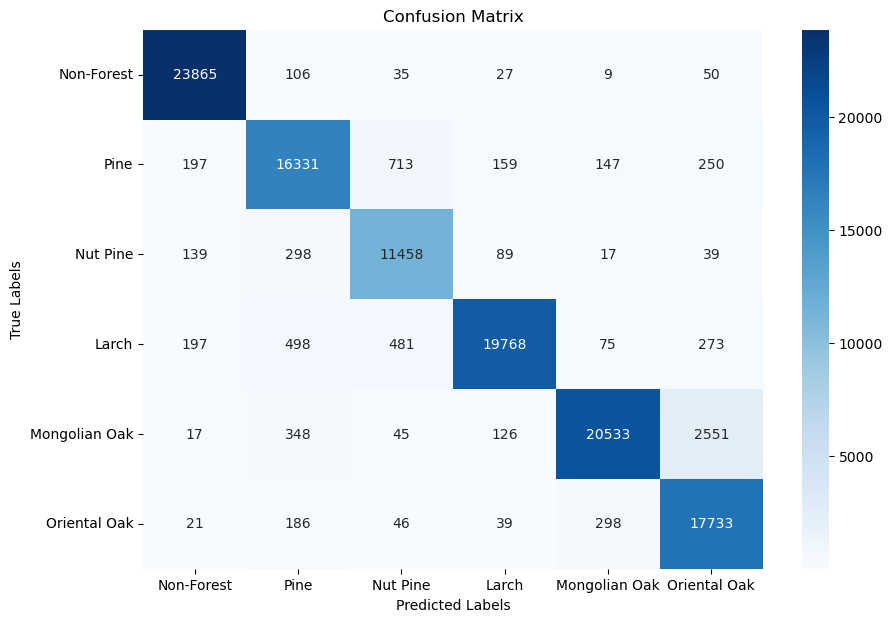

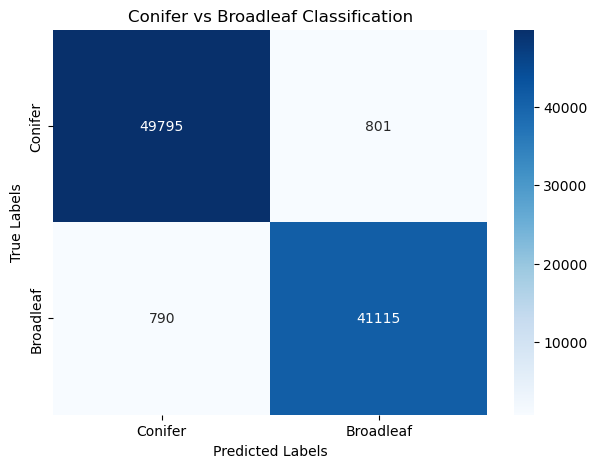

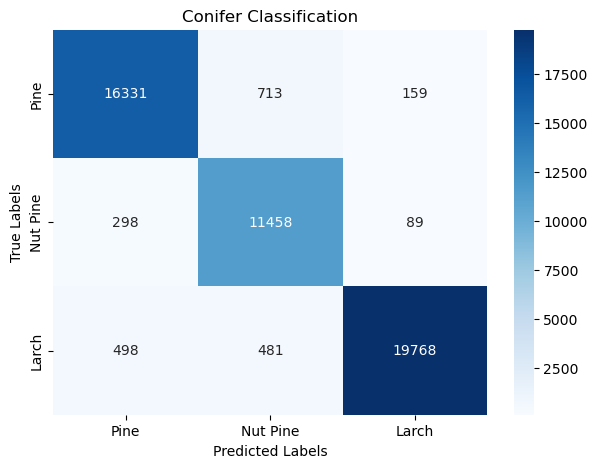

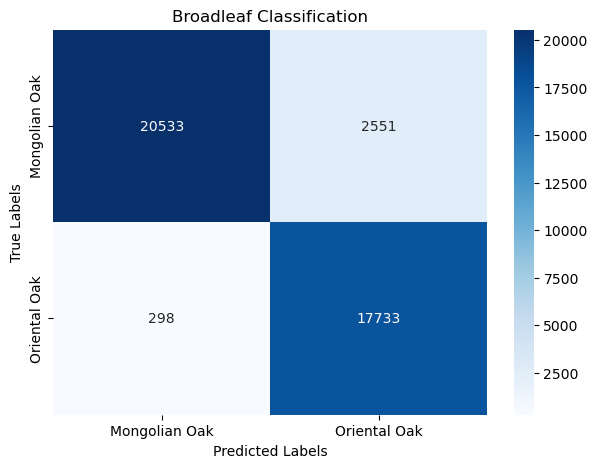


validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:05<00:00, 213.40it/s]


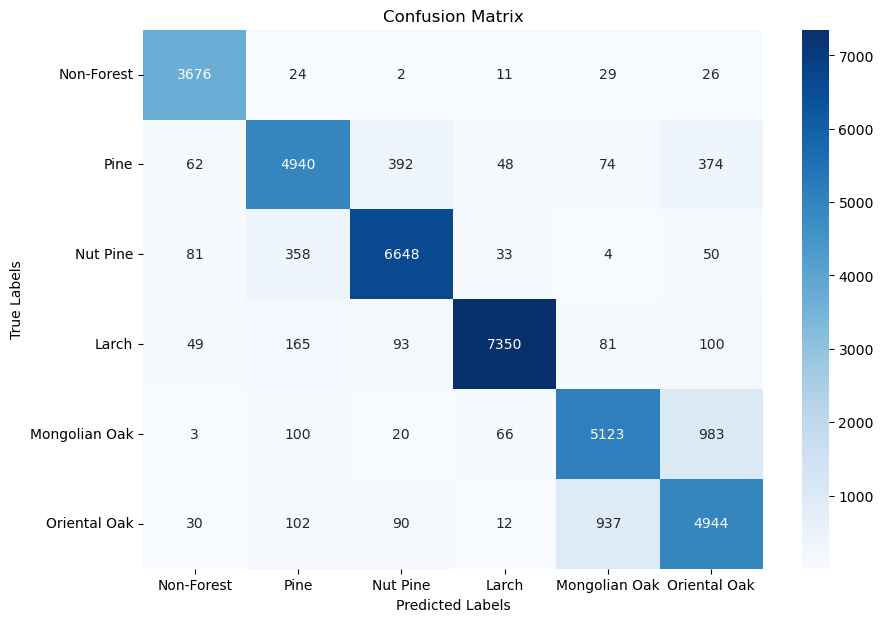

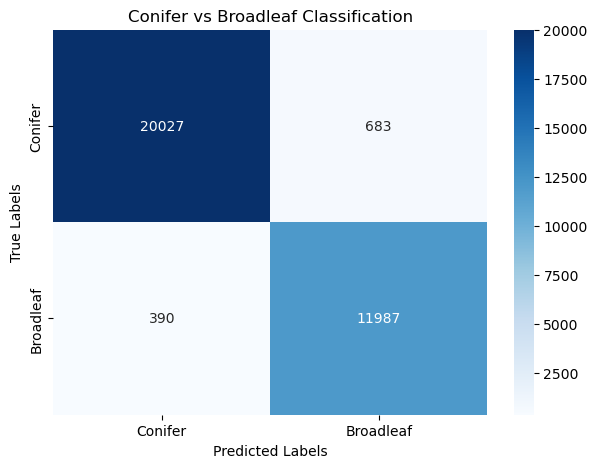

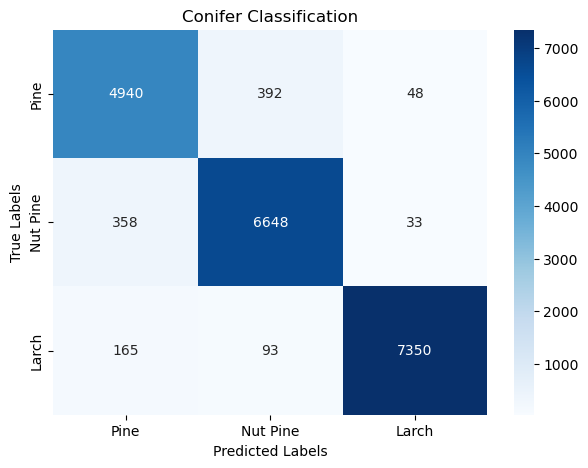

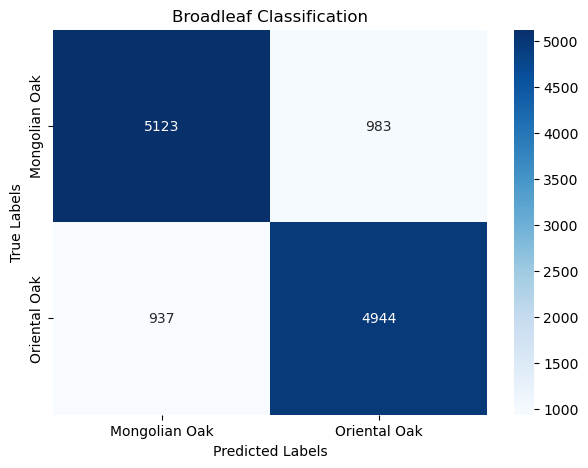

,precision,recall,f1-score,support,Category
Non-Forest,0.942322,0.975584,0.958665,3768.000000,Overall
Pine,0.868342,0.838710,0.853269,5890.000000,Overall
Nut Pine,0.917598,0.926680,0.922117,7174.000000,Overall
Larch,0.977394,0.937739,0.957156,7838.000000,Overall
Mongolian Oak,0.819942,0.813820,0.816870,6295.000000,Overall
Oriental Oak,0.763316,0.808504,0.785260,6115.000000,Overall
accuracy,0.881365,0.881365,0.881365,0.881365,Overall
macro avg,0.881486,0.883506,0.882223,37080.000000,Overall
weighted avg,0.882904,0.881365,0.881864,37080.000000,Overall
Conifer,0.980898,0.967021,0.973910,20710.000000,Conifer vs Broadleaf


In [10]:
model = ResNetLike(input_channels=60, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
)
torch.save(best_model_state, f"./checkpoints/image_classification/ResNetLike_60_{patch_size}_{num_epochs}.pth")

model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## Sentinel_2 데이터도 추가하여 사용

In [7]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform,
    patch_size = patch_size
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_ndvi_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform,
    patch_size = patch_size
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 166.78it/s]



Epoch [1/100], Train Loss: 0.4488, Train Accuracy: 84.05%, Val Loss: 0.4134, Val Accuracy: 86.78%



Epoch 2/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.18it/s]



Epoch [2/100], Train Loss: 0.3172, Train Accuracy: 88.67%, Val Loss: 0.4229, Val Accuracy: 86.89%



Epoch 3/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.30it/s]



Epoch [3/100], Train Loss: 0.2722, Train Accuracy: 90.29%, Val Loss: 0.4437, Val Accuracy: 86.73%



Epoch 4/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.60it/s]



Epoch [4/100], Train Loss: 0.2444, Train Accuracy: 91.48%, Val Loss: 0.4557, Val Accuracy: 87.06%



Epoch 5/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.04it/s]



Epoch [5/100], Train Loss: 0.2213, Train Accuracy: 92.22%, Val Loss: 0.4757, Val Accuracy: 85.94%



Epoch 6/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.56it/s]



Epoch [6/100], Train Loss: 0.2004, Train Accuracy: 92.82%, Val Loss: 0.5428, Val Accuracy: 84.40%



Epoch 7/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.87it/s]



Epoch [7/100], Train Loss: 0.1859, Train Accuracy: 93.37%, Val Loss: 0.4925, Val Accuracy: 87.81%



Epoch 8/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.62it/s]



Epoch [8/100], Train Loss: 0.1754, Train Accuracy: 93.71%, Val Loss: 0.4913, Val Accuracy: 86.56%



Epoch 9/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.81it/s]



Epoch [9/100], Train Loss: 0.1672, Train Accuracy: 94.03%, Val Loss: 0.4995, Val Accuracy: 87.77%



Epoch 10/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.01it/s]



Epoch [10/100], Train Loss: 0.1572, Train Accuracy: 94.33%, Val Loss: 0.5358, Val Accuracy: 86.97%



Epoch 11/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.58it/s]



Epoch [11/100], Train Loss: 0.1507, Train Accuracy: 94.64%, Val Loss: 0.5194, Val Accuracy: 86.19%



Epoch 12/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.89it/s]



Epoch [12/100], Train Loss: 0.1446, Train Accuracy: 94.81%, Val Loss: 0.5765, Val Accuracy: 86.08%



Epoch 13/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.47it/s]



Epoch [13/100], Train Loss: 0.1384, Train Accuracy: 95.05%, Val Loss: 0.4979, Val Accuracy: 87.24%



Epoch 14/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.10it/s]



Epoch [14/100], Train Loss: 0.1340, Train Accuracy: 95.23%, Val Loss: 0.5192, Val Accuracy: 87.03%



Epoch 15/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.92it/s]



Epoch [15/100], Train Loss: 0.1286, Train Accuracy: 95.46%, Val Loss: 0.5802, Val Accuracy: 86.67%



Epoch 16/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.14it/s]



Epoch [16/100], Train Loss: 0.1237, Train Accuracy: 95.59%, Val Loss: 0.5933, Val Accuracy: 86.53%



Epoch 17/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.70it/s]



Epoch [17/100], Train Loss: 0.1191, Train Accuracy: 95.74%, Val Loss: 0.5592, Val Accuracy: 86.98%



Epoch 18/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.79it/s]



Epoch [18/100], Train Loss: 0.1152, Train Accuracy: 95.84%, Val Loss: 0.6547, Val Accuracy: 86.43%



Epoch 19/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.45it/s]



Epoch [19/100], Train Loss: 0.1124, Train Accuracy: 96.01%, Val Loss: 0.6519, Val Accuracy: 86.07%



Epoch 20/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.25it/s]



Epoch [20/100], Train Loss: 0.1091, Train Accuracy: 96.09%, Val Loss: 0.7776, Val Accuracy: 84.86%



Epoch 21/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.02it/s]



Epoch [21/100], Train Loss: 0.1076, Train Accuracy: 96.17%, Val Loss: 0.5477, Val Accuracy: 86.82%



Epoch 22/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.34it/s]



Epoch [22/100], Train Loss: 0.1044, Train Accuracy: 96.29%, Val Loss: 0.7503, Val Accuracy: 84.93%



Epoch 23/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.15it/s]



Epoch [23/100], Train Loss: 0.1018, Train Accuracy: 96.38%, Val Loss: 0.5668, Val Accuracy: 86.63%



Epoch 24/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.11it/s]



Epoch [24/100], Train Loss: 0.0978, Train Accuracy: 96.50%, Val Loss: 0.5330, Val Accuracy: 87.66%



Epoch 25/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.11it/s]



Epoch [25/100], Train Loss: 0.0975, Train Accuracy: 96.58%, Val Loss: 0.6581, Val Accuracy: 86.50%



Epoch 26/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.71it/s]



Epoch [26/100], Train Loss: 0.0931, Train Accuracy: 96.67%, Val Loss: 0.5973, Val Accuracy: 87.50%



Epoch 27/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.61it/s]



Epoch [27/100], Train Loss: 0.0902, Train Accuracy: 96.76%, Val Loss: 0.6594, Val Accuracy: 86.86%



Epoch 28/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.58it/s]



Epoch [28/100], Train Loss: 0.0905, Train Accuracy: 96.76%, Val Loss: 0.6996, Val Accuracy: 85.49%



Epoch 29/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.70it/s]



Epoch [29/100], Train Loss: 0.0876, Train Accuracy: 96.86%, Val Loss: 0.7032, Val Accuracy: 87.19%



Epoch 30/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.81it/s]



Epoch [30/100], Train Loss: 0.0836, Train Accuracy: 96.97%, Val Loss: 0.7742, Val Accuracy: 85.38%



Epoch 31/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.57it/s]



Epoch [31/100], Train Loss: 0.0848, Train Accuracy: 96.95%, Val Loss: 0.6668, Val Accuracy: 86.60%



Epoch 32/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.99it/s]



Epoch [32/100], Train Loss: 0.0834, Train Accuracy: 96.98%, Val Loss: 0.7229, Val Accuracy: 85.23%



Epoch 33/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.14it/s]



Epoch [33/100], Train Loss: 0.0801, Train Accuracy: 97.15%, Val Loss: 0.6965, Val Accuracy: 86.15%



Epoch 34/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.65it/s]



Epoch [34/100], Train Loss: 0.0789, Train Accuracy: 97.18%, Val Loss: 0.6858, Val Accuracy: 86.87%



Epoch 35/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.86it/s]



Epoch [35/100], Train Loss: 0.0768, Train Accuracy: 97.27%, Val Loss: 0.8157, Val Accuracy: 85.79%



Epoch 36/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.29it/s]



Epoch [36/100], Train Loss: 0.0768, Train Accuracy: 97.23%, Val Loss: 0.7355, Val Accuracy: 85.53%



Epoch 37/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.73it/s]



Epoch [37/100], Train Loss: 0.0750, Train Accuracy: 97.38%, Val Loss: 0.7360, Val Accuracy: 87.03%



Epoch 38/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.25it/s]



Epoch [38/100], Train Loss: 0.0730, Train Accuracy: 97.41%, Val Loss: 0.8810, Val Accuracy: 85.75%



Epoch 39/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.81it/s]



Epoch [39/100], Train Loss: 0.0718, Train Accuracy: 97.44%, Val Loss: 0.8083, Val Accuracy: 86.26%



Epoch 40/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.18it/s]



Epoch [40/100], Train Loss: 0.0697, Train Accuracy: 97.51%, Val Loss: 0.7247, Val Accuracy: 86.57%



Epoch 41/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.48it/s]



Epoch [41/100], Train Loss: 0.0689, Train Accuracy: 97.52%, Val Loss: 0.7413, Val Accuracy: 86.38%



Epoch 42/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.52it/s]



Epoch [42/100], Train Loss: 0.0697, Train Accuracy: 97.51%, Val Loss: 0.8018, Val Accuracy: 85.02%



Epoch 43/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.48it/s]



Epoch [43/100], Train Loss: 0.0671, Train Accuracy: 97.60%, Val Loss: 0.7864, Val Accuracy: 86.84%



Epoch 44/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.38it/s]



Epoch [44/100], Train Loss: 0.0660, Train Accuracy: 97.65%, Val Loss: 0.7111, Val Accuracy: 86.63%



Epoch 45/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.45it/s]



Epoch [45/100], Train Loss: 0.0665, Train Accuracy: 97.64%, Val Loss: 0.7594, Val Accuracy: 86.06%



Epoch 46/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.49it/s]



Epoch [46/100], Train Loss: 0.0636, Train Accuracy: 97.70%, Val Loss: 0.7590, Val Accuracy: 86.65%



Epoch 47/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.30it/s]



Epoch [47/100], Train Loss: 0.0621, Train Accuracy: 97.77%, Val Loss: 0.8407, Val Accuracy: 85.40%



Epoch 48/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.77it/s]



Epoch [48/100], Train Loss: 0.0629, Train Accuracy: 97.73%, Val Loss: 0.8589, Val Accuracy: 84.78%



Epoch 49/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.96it/s]



Epoch [49/100], Train Loss: 0.0619, Train Accuracy: 97.78%, Val Loss: 0.8848, Val Accuracy: 86.43%



Epoch 50/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.07it/s]



Epoch [50/100], Train Loss: 0.0609, Train Accuracy: 97.80%, Val Loss: 0.8303, Val Accuracy: 86.58%



Epoch 51/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.19it/s]



Epoch [51/100], Train Loss: 0.0610, Train Accuracy: 97.85%, Val Loss: 0.7478, Val Accuracy: 87.20%



Epoch 52/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 166.81it/s]



Epoch [52/100], Train Loss: 0.0587, Train Accuracy: 97.88%, Val Loss: 0.8049, Val Accuracy: 85.98%



Epoch 53/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.72it/s]



Epoch [53/100], Train Loss: 0.0587, Train Accuracy: 97.84%, Val Loss: 0.8488, Val Accuracy: 86.22%



Epoch 54/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 166.90it/s]



Epoch [54/100], Train Loss: 0.0571, Train Accuracy: 97.93%, Val Loss: 0.8255, Val Accuracy: 86.76%



Epoch 55/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.62it/s]



Epoch [55/100], Train Loss: 0.0555, Train Accuracy: 98.02%, Val Loss: 0.8582, Val Accuracy: 86.57%



Epoch 56/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 166.27it/s]



Epoch [56/100], Train Loss: 0.0555, Train Accuracy: 97.99%, Val Loss: 0.8605, Val Accuracy: 86.44%



Epoch 57/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.54it/s]



Epoch [57/100], Train Loss: 0.0547, Train Accuracy: 98.06%, Val Loss: 0.8780, Val Accuracy: 85.69%



Epoch 58/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.78it/s]



Epoch [58/100], Train Loss: 0.0533, Train Accuracy: 98.12%, Val Loss: 0.8562, Val Accuracy: 85.87%



Epoch 59/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.28it/s]



Epoch [59/100], Train Loss: 0.0537, Train Accuracy: 98.11%, Val Loss: 0.7341, Val Accuracy: 87.36%



Epoch 60/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.21it/s]



Epoch [60/100], Train Loss: 0.0526, Train Accuracy: 98.13%, Val Loss: 0.8795, Val Accuracy: 86.20%



Epoch 61/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.99it/s]



Epoch [61/100], Train Loss: 0.0507, Train Accuracy: 98.22%, Val Loss: 0.8167, Val Accuracy: 86.40%



Epoch 62/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.87it/s]



Epoch [62/100], Train Loss: 0.0516, Train Accuracy: 98.19%, Val Loss: 0.8512, Val Accuracy: 85.98%



Epoch 63/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.14it/s]



Epoch [63/100], Train Loss: 0.0506, Train Accuracy: 98.21%, Val Loss: 0.7886, Val Accuracy: 86.28%



Epoch 64/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.03it/s]



Epoch [64/100], Train Loss: 0.0503, Train Accuracy: 98.24%, Val Loss: 0.7734, Val Accuracy: 86.66%



Epoch 65/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.25it/s]



Epoch [65/100], Train Loss: 0.0504, Train Accuracy: 98.20%, Val Loss: 0.7767, Val Accuracy: 86.56%



Epoch 66/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.19it/s]



Epoch [66/100], Train Loss: 0.0485, Train Accuracy: 98.30%, Val Loss: 0.9334, Val Accuracy: 87.19%



Epoch 67/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.64it/s]



Epoch [67/100], Train Loss: 0.0482, Train Accuracy: 98.25%, Val Loss: 0.8658, Val Accuracy: 86.28%



Epoch 68/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.80it/s]



Epoch [68/100], Train Loss: 0.0467, Train Accuracy: 98.35%, Val Loss: 0.8255, Val Accuracy: 87.24%



Epoch 69/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.97it/s]



Epoch [69/100], Train Loss: 0.0472, Train Accuracy: 98.32%, Val Loss: 0.7877, Val Accuracy: 86.02%



Epoch 70/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.48it/s]



Epoch [70/100], Train Loss: 0.0471, Train Accuracy: 98.28%, Val Loss: 0.8861, Val Accuracy: 86.24%



Epoch 71/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.91it/s]



Epoch [71/100], Train Loss: 0.0465, Train Accuracy: 98.37%, Val Loss: 0.7808, Val Accuracy: 87.50%



Epoch 72/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.31it/s]



Epoch [72/100], Train Loss: 0.0449, Train Accuracy: 98.40%, Val Loss: 0.9143, Val Accuracy: 86.70%



Epoch 73/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.56it/s]



Epoch [73/100], Train Loss: 0.0466, Train Accuracy: 98.33%, Val Loss: 0.8694, Val Accuracy: 86.81%



Epoch 74/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.83it/s]



Epoch [74/100], Train Loss: 0.0444, Train Accuracy: 98.36%, Val Loss: 0.7026, Val Accuracy: 88.26%



Epoch 75/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.35it/s]



Epoch [75/100], Train Loss: 0.0442, Train Accuracy: 98.43%, Val Loss: 0.8002, Val Accuracy: 87.36%



Epoch 76/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.22it/s]



Epoch [76/100], Train Loss: 0.0440, Train Accuracy: 98.43%, Val Loss: 0.9486, Val Accuracy: 85.84%



Epoch 77/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.28it/s]



Epoch [77/100], Train Loss: 0.0419, Train Accuracy: 98.50%, Val Loss: 0.9838, Val Accuracy: 85.59%



Epoch 78/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.47it/s]



Epoch [78/100], Train Loss: 0.0441, Train Accuracy: 98.49%, Val Loss: 0.8184, Val Accuracy: 87.85%



Epoch 79/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.46it/s]



Epoch [79/100], Train Loss: 0.0437, Train Accuracy: 98.49%, Val Loss: 0.7935, Val Accuracy: 87.33%



Epoch 80/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.36it/s]



Epoch [80/100], Train Loss: 0.0424, Train Accuracy: 98.46%, Val Loss: 0.8138, Val Accuracy: 87.49%



Epoch 81/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.75it/s]



Epoch [81/100], Train Loss: 0.0427, Train Accuracy: 98.49%, Val Loss: 0.8749, Val Accuracy: 86.70%



Epoch 82/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.49it/s]



Epoch [82/100], Train Loss: 0.0421, Train Accuracy: 98.50%, Val Loss: 0.7906, Val Accuracy: 87.35%



Epoch 83/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.25it/s]



Epoch [83/100], Train Loss: 0.0408, Train Accuracy: 98.53%, Val Loss: 1.6662, Val Accuracy: 84.53%



Epoch 84/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.62it/s]



Epoch [84/100], Train Loss: 0.0398, Train Accuracy: 98.55%, Val Loss: 0.9789, Val Accuracy: 86.37%



Epoch 85/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.55it/s]



Epoch [85/100], Train Loss: 0.0413, Train Accuracy: 98.55%, Val Loss: 0.9066, Val Accuracy: 86.79%



Epoch 86/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 166.96it/s]



Epoch [86/100], Train Loss: 0.0394, Train Accuracy: 98.61%, Val Loss: 0.9231, Val Accuracy: 86.90%



Epoch 87/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.92it/s]



Epoch [87/100], Train Loss: 0.0407, Train Accuracy: 98.55%, Val Loss: 0.9054, Val Accuracy: 86.77%



Epoch 88/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.78it/s]



Epoch [88/100], Train Loss: 0.0396, Train Accuracy: 98.60%, Val Loss: 1.0497, Val Accuracy: 86.03%



Epoch 89/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 167.25it/s]



Epoch [89/100], Train Loss: 0.0397, Train Accuracy: 98.61%, Val Loss: 0.8841, Val Accuracy: 87.26%



Epoch 90/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.13it/s]



Epoch [90/100], Train Loss: 0.0388, Train Accuracy: 98.59%, Val Loss: 0.8844, Val Accuracy: 85.36%



Epoch 91/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.65it/s]



Epoch [91/100], Train Loss: 0.0385, Train Accuracy: 98.63%, Val Loss: 0.9737, Val Accuracy: 86.18%



Epoch 92/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.57it/s]



Epoch [92/100], Train Loss: 0.0374, Train Accuracy: 98.66%, Val Loss: 0.8464, Val Accuracy: 86.85%



Epoch 93/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 171.26it/s]



Epoch [93/100], Train Loss: 0.0376, Train Accuracy: 98.65%, Val Loss: 0.8762, Val Accuracy: 87.83%



Epoch 94/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 169.13it/s]



Epoch [94/100], Train Loss: 0.0379, Train Accuracy: 98.65%, Val Loss: 0.8863, Val Accuracy: 85.57%



Epoch 95/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.75it/s]



Epoch [95/100], Train Loss: 0.0370, Train Accuracy: 98.69%, Val Loss: 0.9249, Val Accuracy: 86.61%



Epoch 96/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 168.24it/s]



Epoch [96/100], Train Loss: 0.0372, Train Accuracy: 98.67%, Val Loss: 0.9325, Val Accuracy: 85.70%



Epoch 97/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.75it/s]



Epoch [97/100], Train Loss: 0.0368, Train Accuracy: 98.73%, Val Loss: 0.8242, Val Accuracy: 87.49%



Epoch 98/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.09it/s]



Epoch [98/100], Train Loss: 0.0373, Train Accuracy: 98.71%, Val Loss: 0.9568, Val Accuracy: 86.48%



Epoch 99/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 171.18it/s]



Epoch [99/100], Train Loss: 0.0363, Train Accuracy: 98.71%, Val Loss: 0.8541, Val Accuracy: 87.55%



Epoch 100/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 170.15it/s]



Epoch [100/100], Train Loss: 0.0353, Train Accuracy: 98.76%, Val Loss: 0.9368, Val Accuracy: 86.62%


train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:21<00:00, 171.30it/s]


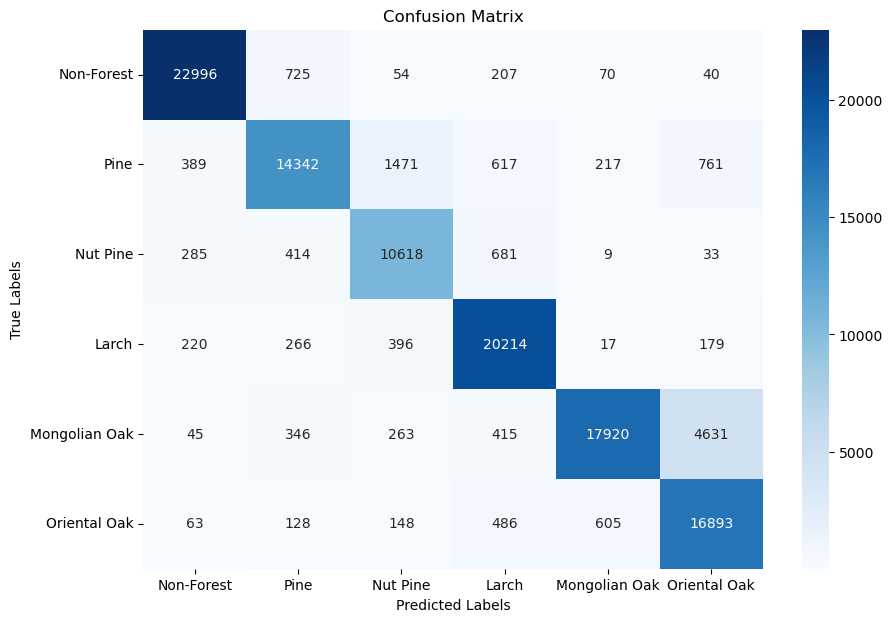

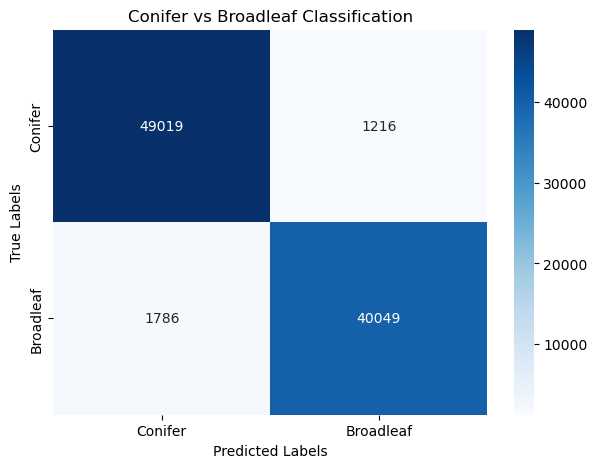

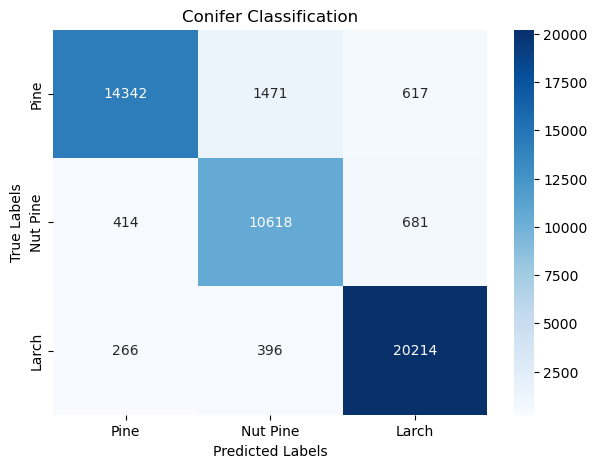

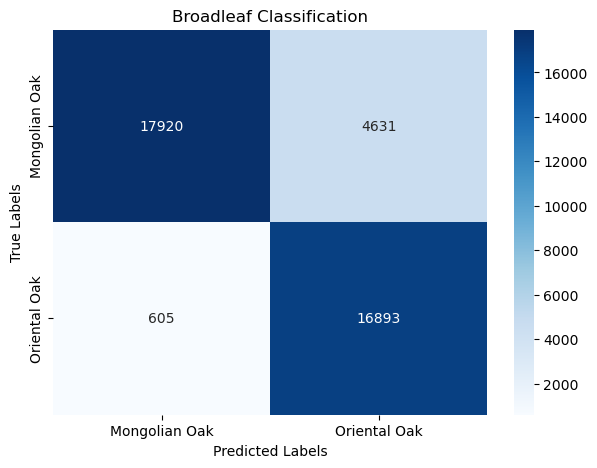


validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:06<00:00, 171.66it/s]


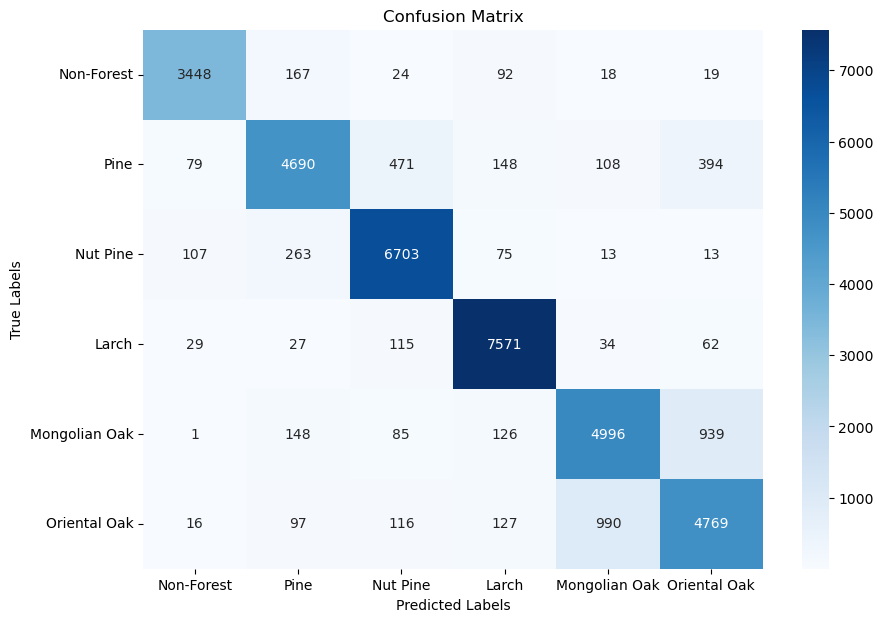

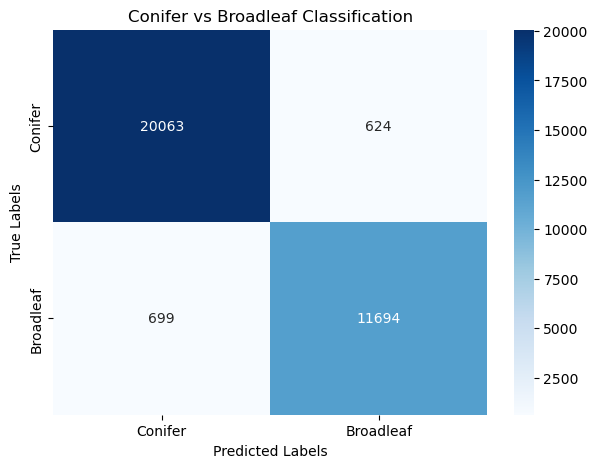

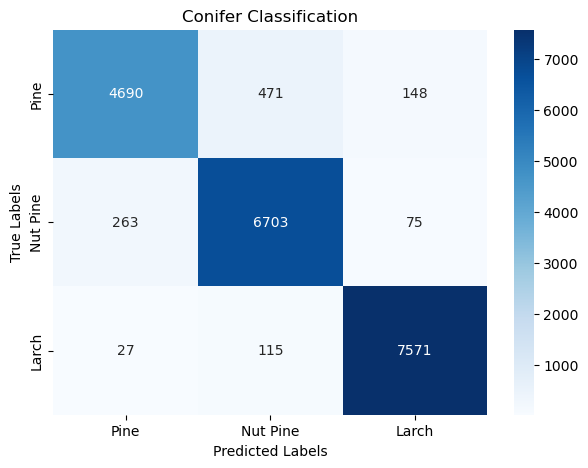

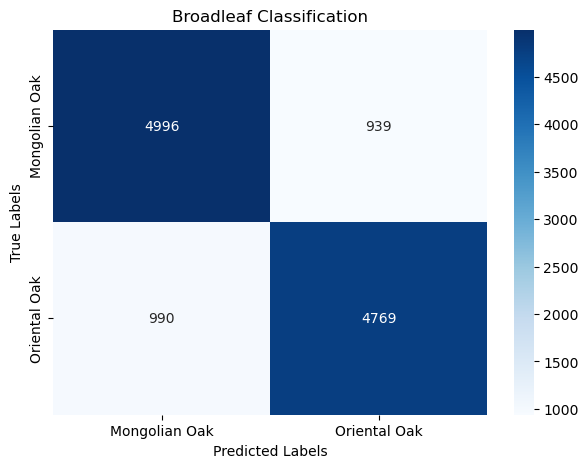

,precision,recall,f1-score,support,Category
Non-Forest,0.936957,0.915074,0.925886,3768.000000,Overall
Pine,0.869807,0.796265,0.831413,5890.000000,Overall
Nut Pine,0.892068,0.934346,0.912718,7174.000000,Overall
Larch,0.930213,0.965935,0.947737,7838.000000,Overall
Mongolian Oak,0.811171,0.793646,0.802313,6295.000000,Overall
Oriental Oak,0.769690,0.779886,0.774754,6115.000000,Overall
accuracy,0.867772,0.867772,0.867772,0.867772,Overall
macro avg,0.868318,0.864192,0.865804,37080.000000,Overall
weighted avg,0.867241,0.867772,0.867048,37080.000000,Overall
Conifer,0.966333,0.969836,0.968081,20687.000000,Conifer vs Broadleaf


In [8]:
model = ResNetLike(input_channels=120, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
)
torch.save(best_model_state, f"./checkpoints/image_classification/ResNetLike_120_{patch_size}_{num_epochs}.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)

## NDVI 없이 Planet + Sentinel_2 데이터 사용

In [7]:
train_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = lambda box_number: not test_filter(box_number),
    transform=transform,
    patch_size = patch_size
)

val_dataset = TiffDataset(
    large_tif_dir = os.path.join(source_data_dir,"with_s2"),
    file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
    label_file = label_file_path,
    box_filter_fn = test_filter,
    transform=transform,
    patch_size = patch_size
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epoch 1/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.02it/s]



Epoch [1/100], Train Loss: 0.4443, Train Accuracy: 84.11%, Val Loss: 0.3924, Val Accuracy: 87.06%



Epoch 2/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.29it/s]



Epoch [2/100], Train Loss: 0.3232, Train Accuracy: 88.28%, Val Loss: 0.3855, Val Accuracy: 88.47%



Epoch 3/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.30it/s]



Epoch [3/100], Train Loss: 0.2777, Train Accuracy: 90.08%, Val Loss: 0.4464, Val Accuracy: 86.46%



Epoch 4/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.19it/s]



Epoch [4/100], Train Loss: 0.2466, Train Accuracy: 91.21%, Val Loss: 0.4620, Val Accuracy: 87.55%



Epoch 5/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.67it/s]



Epoch [5/100], Train Loss: 0.2242, Train Accuracy: 92.01%, Val Loss: 0.4821, Val Accuracy: 87.12%



Epoch 6/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.98it/s]



Epoch [6/100], Train Loss: 0.2041, Train Accuracy: 92.69%, Val Loss: 0.4691, Val Accuracy: 87.52%



Epoch 7/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.56it/s]



Epoch [7/100], Train Loss: 0.1941, Train Accuracy: 92.92%, Val Loss: 0.5685, Val Accuracy: 86.14%



Epoch 8/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.08it/s]



Epoch [8/100], Train Loss: 0.1810, Train Accuracy: 93.58%, Val Loss: 0.4799, Val Accuracy: 87.25%



Epoch 9/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.09it/s]



Epoch [9/100], Train Loss: 0.1722, Train Accuracy: 93.87%, Val Loss: 0.5170, Val Accuracy: 86.48%



Epoch 10/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.57it/s]



Epoch [10/100], Train Loss: 0.1624, Train Accuracy: 94.16%, Val Loss: 0.5288, Val Accuracy: 87.02%



Epoch 11/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.39it/s]



Epoch [11/100], Train Loss: 0.1575, Train Accuracy: 94.34%, Val Loss: 0.5281, Val Accuracy: 86.86%



Epoch 12/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.70it/s]



Epoch [12/100], Train Loss: 0.1502, Train Accuracy: 94.63%, Val Loss: 0.5982, Val Accuracy: 85.61%



Epoch 13/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.97it/s]



Epoch [13/100], Train Loss: 0.1430, Train Accuracy: 94.94%, Val Loss: 0.5951, Val Accuracy: 86.81%



Epoch 14/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.29it/s]



Epoch [14/100], Train Loss: 0.1397, Train Accuracy: 95.03%, Val Loss: 0.5339, Val Accuracy: 86.88%



Epoch 15/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.22it/s]



Epoch [15/100], Train Loss: 0.1339, Train Accuracy: 95.23%, Val Loss: 0.6167, Val Accuracy: 86.49%



Epoch 16/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.92it/s]



Epoch [16/100], Train Loss: 0.1297, Train Accuracy: 95.37%, Val Loss: 0.4941, Val Accuracy: 87.14%



Epoch 17/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.90it/s]



Epoch [17/100], Train Loss: 0.1273, Train Accuracy: 95.42%, Val Loss: 0.6483, Val Accuracy: 86.19%



Epoch 18/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.94it/s]



Epoch [18/100], Train Loss: 0.1221, Train Accuracy: 95.67%, Val Loss: 0.6292, Val Accuracy: 85.36%



Epoch 19/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.45it/s]



Epoch [19/100], Train Loss: 0.1161, Train Accuracy: 95.84%, Val Loss: 0.7025, Val Accuracy: 85.54%



Epoch 20/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.49it/s]



Epoch [20/100], Train Loss: 0.1161, Train Accuracy: 95.90%, Val Loss: 0.6232, Val Accuracy: 85.70%



Epoch 21/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.60it/s]



Epoch [21/100], Train Loss: 0.1135, Train Accuracy: 95.99%, Val Loss: 0.5572, Val Accuracy: 87.73%



Epoch 22/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.96it/s]



Epoch [22/100], Train Loss: 0.1081, Train Accuracy: 96.07%, Val Loss: 0.5939, Val Accuracy: 86.77%



Epoch 23/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.17it/s]



Epoch [23/100], Train Loss: 0.1053, Train Accuracy: 96.23%, Val Loss: 0.7768, Val Accuracy: 85.58%



Epoch 24/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.37it/s]



Epoch [24/100], Train Loss: 0.1027, Train Accuracy: 96.33%, Val Loss: 0.7181, Val Accuracy: 85.74%



Epoch 25/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.73it/s]



Epoch [25/100], Train Loss: 0.1035, Train Accuracy: 96.32%, Val Loss: 0.7000, Val Accuracy: 85.70%



Epoch 26/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.84it/s]



Epoch [26/100], Train Loss: 0.0995, Train Accuracy: 96.42%, Val Loss: 0.6932, Val Accuracy: 85.87%



Epoch 27/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.17it/s]



Epoch [27/100], Train Loss: 0.0989, Train Accuracy: 96.51%, Val Loss: 0.6587, Val Accuracy: 84.71%



Epoch 28/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.55it/s]



Epoch [28/100], Train Loss: 0.0957, Train Accuracy: 96.56%, Val Loss: 0.8183, Val Accuracy: 84.97%



Epoch 29/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.91it/s]



Epoch [29/100], Train Loss: 0.0927, Train Accuracy: 96.71%, Val Loss: 0.6353, Val Accuracy: 86.57%



Epoch 30/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.80it/s]



Epoch [30/100], Train Loss: 0.0916, Train Accuracy: 96.72%, Val Loss: 0.7321, Val Accuracy: 84.45%



Epoch 31/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.99it/s]



Epoch [31/100], Train Loss: 0.0889, Train Accuracy: 96.82%, Val Loss: 0.6250, Val Accuracy: 86.90%



Epoch 32/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.19it/s]



Epoch [32/100], Train Loss: 0.0880, Train Accuracy: 96.87%, Val Loss: 0.7677, Val Accuracy: 85.36%



Epoch 33/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.76it/s]



Epoch [33/100], Train Loss: 0.0861, Train Accuracy: 96.87%, Val Loss: 0.8058, Val Accuracy: 86.29%



Epoch 34/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.97it/s]



Epoch [34/100], Train Loss: 0.0851, Train Accuracy: 96.93%, Val Loss: 0.6341, Val Accuracy: 86.26%



Epoch 35/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.32it/s]



Epoch [35/100], Train Loss: 0.0850, Train Accuracy: 96.95%, Val Loss: 0.7425, Val Accuracy: 85.38%



Epoch 36/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.04it/s]



Epoch [36/100], Train Loss: 0.0808, Train Accuracy: 97.06%, Val Loss: 0.7876, Val Accuracy: 84.89%



Epoch 37/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.39it/s]



Epoch [37/100], Train Loss: 0.0803, Train Accuracy: 97.12%, Val Loss: 0.7217, Val Accuracy: 86.45%



Epoch 38/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.37it/s]



Epoch [38/100], Train Loss: 0.0797, Train Accuracy: 97.13%, Val Loss: 0.7810, Val Accuracy: 85.74%



Epoch 39/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.70it/s]



Epoch [39/100], Train Loss: 0.0789, Train Accuracy: 97.18%, Val Loss: 0.7390, Val Accuracy: 86.01%



Epoch 40/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.71it/s]



Epoch [40/100], Train Loss: 0.0764, Train Accuracy: 97.27%, Val Loss: 0.6222, Val Accuracy: 86.62%



Epoch 41/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.58it/s]



Epoch [41/100], Train Loss: 0.0761, Train Accuracy: 97.29%, Val Loss: 0.8804, Val Accuracy: 86.12%



Epoch 42/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.59it/s]



Epoch [42/100], Train Loss: 0.0743, Train Accuracy: 97.31%, Val Loss: 0.6566, Val Accuracy: 86.72%



Epoch 43/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.41it/s]



Epoch [43/100], Train Loss: 0.0723, Train Accuracy: 97.37%, Val Loss: 0.7251, Val Accuracy: 86.84%



Epoch 44/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.39it/s]



Epoch [44/100], Train Loss: 0.0712, Train Accuracy: 97.47%, Val Loss: 0.8545, Val Accuracy: 85.82%



Epoch 45/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.07it/s]



Epoch [45/100], Train Loss: 0.0705, Train Accuracy: 97.45%, Val Loss: 0.7860, Val Accuracy: 86.15%



Epoch 46/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.55it/s]



Epoch [46/100], Train Loss: 0.0679, Train Accuracy: 97.54%, Val Loss: 0.7112, Val Accuracy: 86.87%



Epoch 47/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.53it/s]



Epoch [47/100], Train Loss: 0.0681, Train Accuracy: 97.54%, Val Loss: 0.9727, Val Accuracy: 84.81%



Epoch 48/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.26it/s]



Epoch [48/100], Train Loss: 0.0671, Train Accuracy: 97.60%, Val Loss: 0.8900, Val Accuracy: 86.20%



Epoch 49/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.89it/s]



Epoch [49/100], Train Loss: 0.0664, Train Accuracy: 97.62%, Val Loss: 0.8840, Val Accuracy: 84.99%



Epoch 50/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 172.57it/s]



Epoch [50/100], Train Loss: 0.0665, Train Accuracy: 97.62%, Val Loss: 0.7031, Val Accuracy: 86.60%



Epoch 51/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.11it/s]



Epoch [51/100], Train Loss: 0.0639, Train Accuracy: 97.73%, Val Loss: 0.8113, Val Accuracy: 85.59%



Epoch 52/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.43it/s]



Epoch [52/100], Train Loss: 0.0650, Train Accuracy: 97.62%, Val Loss: 0.8308, Val Accuracy: 86.60%



Epoch 53/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.26it/s]



Epoch [53/100], Train Loss: 0.0618, Train Accuracy: 97.75%, Val Loss: 0.7910, Val Accuracy: 86.35%



Epoch 54/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.45it/s]



Epoch [54/100], Train Loss: 0.0624, Train Accuracy: 97.78%, Val Loss: 0.8690, Val Accuracy: 85.09%



Epoch 55/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.46it/s]



Epoch [55/100], Train Loss: 0.0622, Train Accuracy: 97.76%, Val Loss: 0.9972, Val Accuracy: 84.72%



Epoch 56/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.68it/s]



Epoch [56/100], Train Loss: 0.0611, Train Accuracy: 97.82%, Val Loss: 0.7777, Val Accuracy: 85.91%



Epoch 57/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.88it/s]



Epoch [57/100], Train Loss: 0.0606, Train Accuracy: 97.83%, Val Loss: 0.8322, Val Accuracy: 85.65%



Epoch 58/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.53it/s]



Epoch [58/100], Train Loss: 0.0601, Train Accuracy: 97.86%, Val Loss: 0.8364, Val Accuracy: 85.89%



Epoch 59/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 177.17it/s]



Epoch [59/100], Train Loss: 0.0592, Train Accuracy: 97.90%, Val Loss: 0.9149, Val Accuracy: 85.18%



Epoch 60/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.85it/s]



Epoch [60/100], Train Loss: 0.0584, Train Accuracy: 97.90%, Val Loss: 0.8778, Val Accuracy: 85.15%



Epoch 61/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.65it/s]



Epoch [61/100], Train Loss: 0.0559, Train Accuracy: 97.98%, Val Loss: 0.7382, Val Accuracy: 86.68%



Epoch 62/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.94it/s]



Epoch [62/100], Train Loss: 0.0557, Train Accuracy: 97.99%, Val Loss: 0.8662, Val Accuracy: 85.91%



Epoch 63/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.29it/s]



Epoch [63/100], Train Loss: 0.0563, Train Accuracy: 97.95%, Val Loss: 0.9630, Val Accuracy: 84.09%



Epoch 64/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.41it/s]



Epoch [64/100], Train Loss: 0.0562, Train Accuracy: 97.98%, Val Loss: 0.9244, Val Accuracy: 85.39%



Epoch 65/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.78it/s]



Epoch [65/100], Train Loss: 0.0547, Train Accuracy: 98.05%, Val Loss: 0.9002, Val Accuracy: 85.50%



Epoch 66/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.24it/s]



Epoch [66/100], Train Loss: 0.0528, Train Accuracy: 98.12%, Val Loss: 0.8352, Val Accuracy: 86.22%



Epoch 67/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.08it/s]



Epoch [67/100], Train Loss: 0.0537, Train Accuracy: 98.09%, Val Loss: 0.8966, Val Accuracy: 85.43%



Epoch 68/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.16it/s]



Epoch [68/100], Train Loss: 0.0537, Train Accuracy: 98.09%, Val Loss: 0.8390, Val Accuracy: 86.28%



Epoch 69/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.31it/s]



Epoch [69/100], Train Loss: 0.0514, Train Accuracy: 98.18%, Val Loss: 0.9709, Val Accuracy: 86.09%



Epoch 70/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.38it/s]



Epoch [70/100], Train Loss: 0.0522, Train Accuracy: 98.17%, Val Loss: 0.8881, Val Accuracy: 87.08%



Epoch 71/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.02it/s]



Epoch [71/100], Train Loss: 0.0530, Train Accuracy: 98.11%, Val Loss: 0.9620, Val Accuracy: 85.00%



Epoch 72/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.28it/s]



Epoch [72/100], Train Loss: 0.0499, Train Accuracy: 98.23%, Val Loss: 0.9450, Val Accuracy: 84.18%



Epoch 73/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.29it/s]



Epoch [73/100], Train Loss: 0.0497, Train Accuracy: 98.22%, Val Loss: 0.8617, Val Accuracy: 85.68%



Epoch 74/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.05it/s]



Epoch [74/100], Train Loss: 0.0479, Train Accuracy: 98.29%, Val Loss: 0.9500, Val Accuracy: 85.73%



Epoch 75/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.23it/s]



Epoch [75/100], Train Loss: 0.0495, Train Accuracy: 98.23%, Val Loss: 0.8918, Val Accuracy: 85.60%



Epoch 76/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.19it/s]



Epoch [76/100], Train Loss: 0.0494, Train Accuracy: 98.26%, Val Loss: 0.8961, Val Accuracy: 86.19%



Epoch 77/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.20it/s]



Epoch [77/100], Train Loss: 0.0481, Train Accuracy: 98.26%, Val Loss: 0.9535, Val Accuracy: 84.97%



Epoch 78/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.49it/s]



Epoch [78/100], Train Loss: 0.0461, Train Accuracy: 98.41%, Val Loss: 0.9241, Val Accuracy: 86.15%



Epoch 79/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.69it/s]



Epoch [79/100], Train Loss: 0.0464, Train Accuracy: 98.36%, Val Loss: 0.9252, Val Accuracy: 86.04%



Epoch 80/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.94it/s]



Epoch [80/100], Train Loss: 0.0479, Train Accuracy: 98.29%, Val Loss: 0.8376, Val Accuracy: 86.85%



Epoch 81/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.37it/s]



Epoch [81/100], Train Loss: 0.0461, Train Accuracy: 98.34%, Val Loss: 0.8154, Val Accuracy: 86.65%



Epoch 82/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.50it/s]



Epoch [82/100], Train Loss: 0.0462, Train Accuracy: 98.37%, Val Loss: 0.8735, Val Accuracy: 85.81%



Epoch 83/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 173.99it/s]



Epoch [83/100], Train Loss: 0.0458, Train Accuracy: 98.37%, Val Loss: 0.9266, Val Accuracy: 85.46%



Epoch 84/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.36it/s]



Epoch [84/100], Train Loss: 0.0451, Train Accuracy: 98.42%, Val Loss: 0.9533, Val Accuracy: 85.58%



Epoch 85/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.60it/s]



Epoch [85/100], Train Loss: 0.0452, Train Accuracy: 98.42%, Val Loss: 0.8831, Val Accuracy: 85.74%



Epoch 86/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.88it/s]



Epoch [86/100], Train Loss: 0.0451, Train Accuracy: 98.42%, Val Loss: 1.2453, Val Accuracy: 85.46%



Epoch 87/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.15it/s]



Epoch [87/100], Train Loss: 0.0442, Train Accuracy: 98.40%, Val Loss: 1.0174, Val Accuracy: 85.63%



Epoch 88/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.78it/s]



Epoch [88/100], Train Loss: 0.0443, Train Accuracy: 98.40%, Val Loss: 1.0402, Val Accuracy: 84.74%



Epoch 89/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.84it/s]



Epoch [89/100], Train Loss: 0.0430, Train Accuracy: 98.48%, Val Loss: 0.8798, Val Accuracy: 86.39%



Epoch 90/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.54it/s]



Epoch [90/100], Train Loss: 0.0437, Train Accuracy: 98.43%, Val Loss: 0.9022, Val Accuracy: 85.94%



Epoch 91/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.62it/s]



Epoch [91/100], Train Loss: 0.0428, Train Accuracy: 98.46%, Val Loss: 1.0845, Val Accuracy: 86.18%



Epoch 92/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.03it/s]



Epoch [92/100], Train Loss: 0.0409, Train Accuracy: 98.57%, Val Loss: 0.9651, Val Accuracy: 86.23%



Epoch 93/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.16it/s]



Epoch [93/100], Train Loss: 0.0430, Train Accuracy: 98.46%, Val Loss: 0.7634, Val Accuracy: 86.90%



Epoch 94/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.04it/s]



Epoch [94/100], Train Loss: 0.0410, Train Accuracy: 98.54%, Val Loss: 2.4350, Val Accuracy: 86.68%



Epoch 95/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.40it/s]



Epoch [95/100], Train Loss: 0.0408, Train Accuracy: 98.53%, Val Loss: 1.0295, Val Accuracy: 85.23%



Epoch 96/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 174.58it/s]



Epoch [96/100], Train Loss: 0.0416, Train Accuracy: 98.51%, Val Loss: 0.9564, Val Accuracy: 86.97%



Epoch 97/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 175.97it/s]



Epoch [97/100], Train Loss: 0.0403, Train Accuracy: 98.58%, Val Loss: 0.9422, Val Accuracy: 86.39%



Epoch 98/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.03it/s]



Epoch [98/100], Train Loss: 0.0408, Train Accuracy: 98.57%, Val Loss: 1.1413, Val Accuracy: 86.09%



Epoch 99/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.73it/s]



Epoch [99/100], Train Loss: 0.0410, Train Accuracy: 98.56%, Val Loss: 1.0367, Val Accuracy: 84.82%



Epoch 100/100 - Validation: 100%|██████████| 1159/1159 [00:06<00:00, 176.49it/s]



Epoch [100/100], Train Loss: 0.0396, Train Accuracy: 98.63%, Val Loss: 1.0167, Val Accuracy: 86.41%


train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:21<00:00, 173.77it/s]


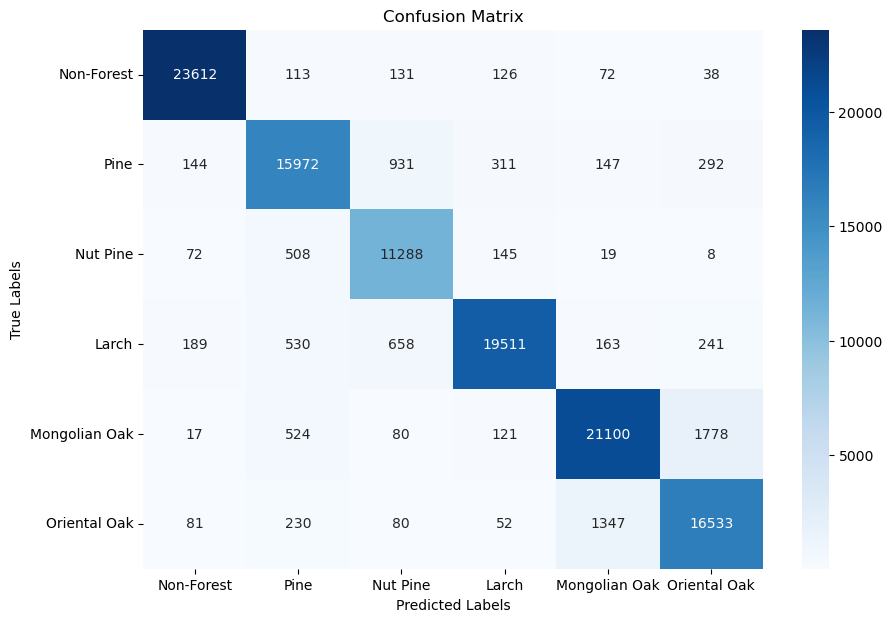

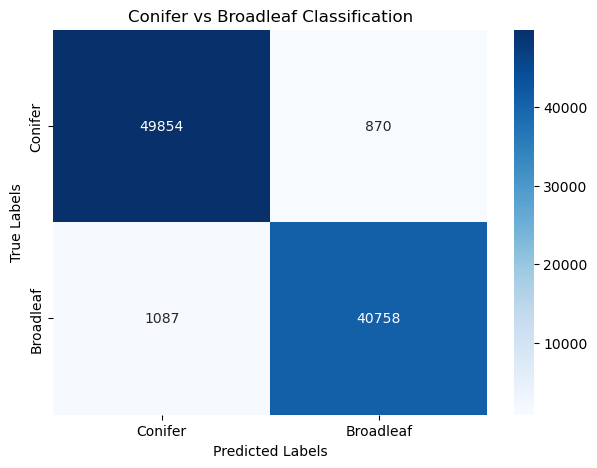

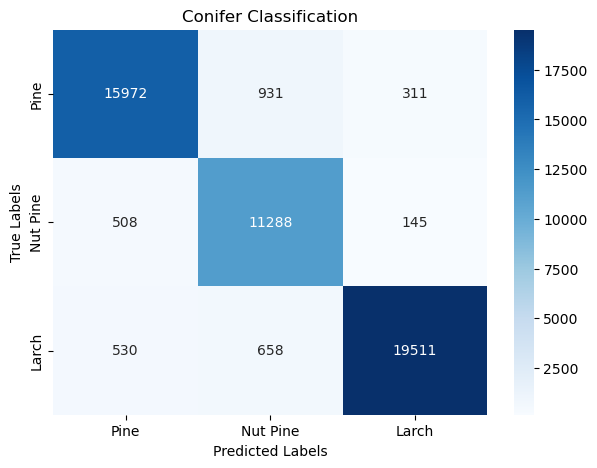

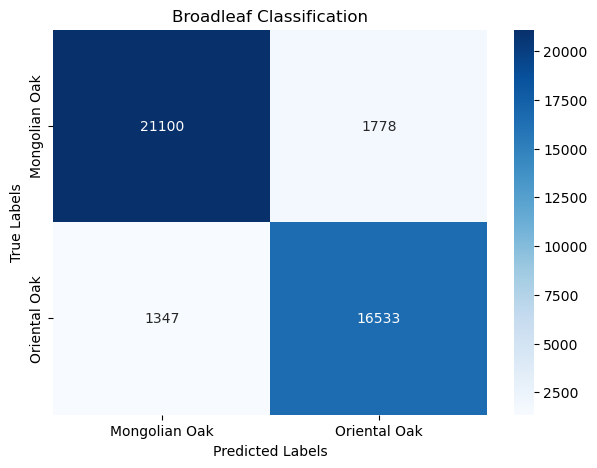


validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:06<00:00, 175.33it/s]


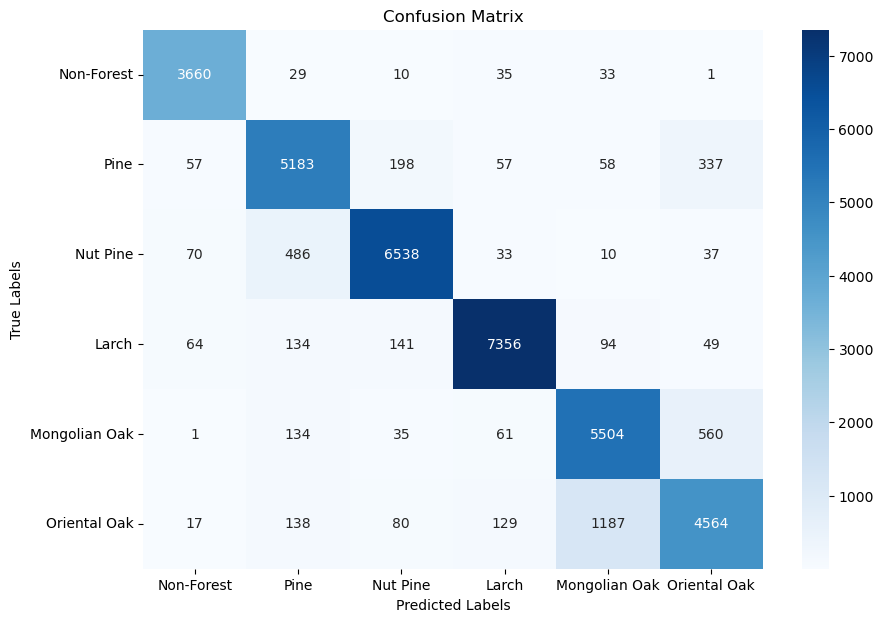

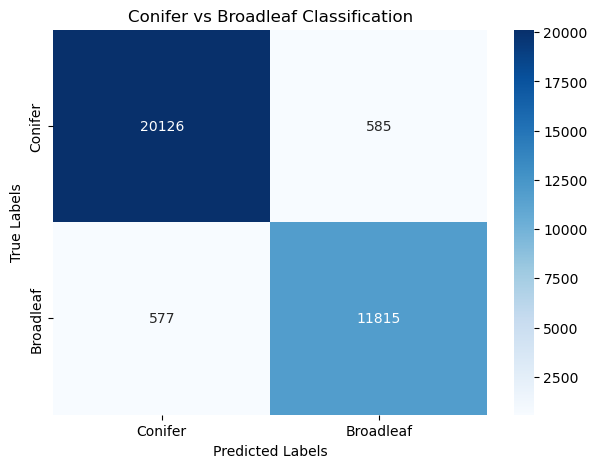

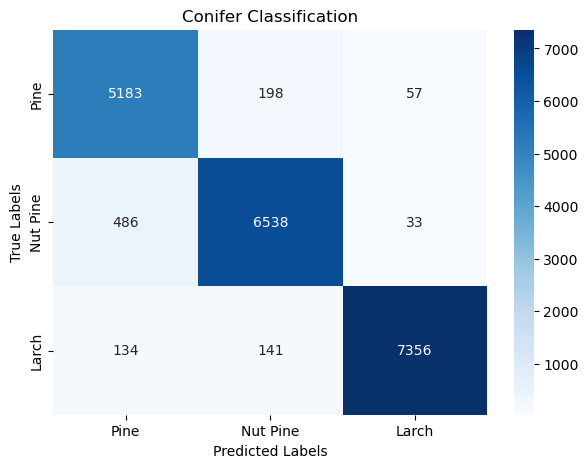

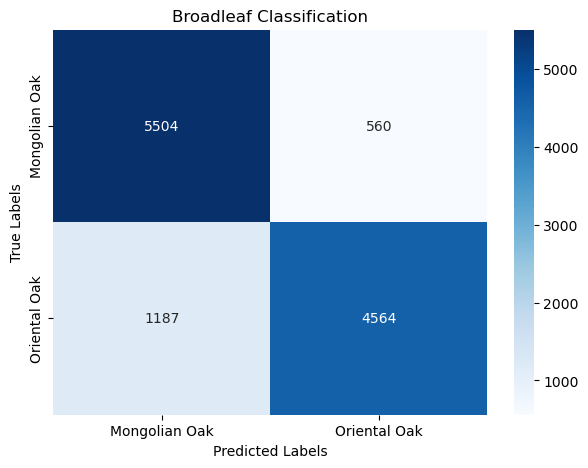

,precision,recall,f1-score,support,Category
Non-Forest,0.945981,0.971338,0.958492,3768.000000,Overall
Pine,0.849115,0.879966,0.864265,5890.000000,Overall
Nut Pine,0.933733,0.911347,0.922404,7174.000000,Overall
Larch,0.958936,0.938505,0.948610,7838.000000,Overall
Mongolian Oak,0.799303,0.874345,0.835141,6295.000000,Overall
Oriental Oak,0.822639,0.746361,0.782646,6115.000000,Overall
accuracy,0.884709,0.884709,0.884709,0.884709,Overall
macro avg,0.884951,0.886977,0.885260,37080.000000,Overall
weighted avg,0.885721,0.884709,0.884513,37080.000000,Overall
Conifer,0.972130,0.971754,0.971942,20711.000000,Conifer vs Broadleaf


In [8]:
model = ResNetLike(input_channels=108, num_classes=6).to(device)
model.apply(he_init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model_state, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
)
torch.save(best_model_state, f"./checkpoints/image_classification/ResNetLike_108_{patch_size}_{num_epochs}.pth")
model.load_state_dict(best_model_state)

print("\ntrain data")
evaluate_model_with_cm(model, train_loader, num_classes=6)
print("\nvalidation data")
evaluate_model_with_cm(model, val_loader, num_classes=6)